<a href="https://colab.research.google.com/github/jeki15/Recommender-System-using-CBF-and-NCF/blob/main/ncf_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Destinasi WIsata di Kota Surabaya Menggunakan Metode Neural Collaborative Filtering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install keras

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dot
from keras.utils import plot_model
from IPython.display import Image
from keras.optimizers import Adam

## Open Data

In [ ]:
df_rating = pd.read_excel('/content/data rating cbf & ncf.xlsx')
df_rating.head()

User_Id  Place_Id  Place_Ratings
0        1       393              5
1        1       405              5
2        1       428              3
3        2       413              3
4        2       437              5

### Drop Duplicated

In [ ]:
df_rating=df_rating.drop_duplicates()
df_rating[df_rating.duplicated(subset=['User_Id', 'Place_Id'], keep=False)]

User_Id  Place_Id  Place_Ratings
4           2       437              5
6           2       437              4
55         17       398              3
56         17       398              4
72         20       425              4
...       ...       ...            ...
1005      288       437              4
1028      297       418              5
1036      297       418              2
1042      299       407              1
1045      299       407              5

[80 rows x 3 columns]

In [ ]:
idx=df_rating.groupby(['User_Id', 'Place_Id'])['Place_Ratings'].idxmax()
df_rating=df_rating.loc[idx].reset_index(drop=True)
df_rating[df_rating.duplicated(subset=['User_Id', 'Place_Id'], keep=False)]

Empty DataFrame
Columns: [User_Id, Place_Id, Place_Ratings]
Index: []

In [ ]:
df_rating.duplicated().sum()

0

In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        998 non-null    int64
 1   Place_Id       998 non-null    int64
 2   Place_Ratings  998 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB


In [ ]:
from sklearn.model_selection import train_test_split

# Need to map Place_Id to [1, num_places]
Place_Id_to_new_id = dict()
id = 1
for index, row in df_rating.iterrows():
    if Place_Id_to_new_id.get(row['Place_Id']) is None:
        Place_Id_to_new_id[row['Place_Id']] = id
        df_rating.at[index, 'Place_Id'] = id
        id += 1
    else:
        df_rating.at[index, 'Place_Id'] = Place_Id_to_new_id.get(row['Place_Id'])
# Need to map User_Id to [1, num_users]
User_Id_to_new_id = dict()
id = 1
for index, row in df_rating.iterrows():
    if User_Id_to_new_id.get(row['User_Id']) is None:
        User_Id_to_new_id[row['User_Id']] = id
        df_rating.at[index, 'User_Id'] = id
        id += 1
    else:
        df_rating.at[index, 'User_Id'] = User_Id_to_new_id.get(row['User_Id'])

num_users = len(df_rating.User_Id.unique())
num_places = len(df_rating.Place_Id.unique())

print('Number of places', num_places)
print('Number of users', num_users)


Number of places 46
Number of users 293


In [ ]:
df_rating

User_Id  Place_Id  Place_Ratings
0          1         1              5
1          1         2              5
2          1         3              3
3          2         4              5
4          2         5              3
..       ...       ...            ...
993      292        23              2
994      293        12              2
995      293        21              4
996      293        35              2
997      293        27              4

[998 rows x 3 columns]

### Train-Test Split

In [ ]:
train, test = train_test_split(df_rating, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
train.info()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 638 entries, 114 to 394
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        638 non-null    int64
 1   Place_Id       638 non-null    int64
 2   Place_Ratings  638 non-null    int64
dtypes: int64(3)
memory usage: 19.9 KB


User_Id  Place_Id  Place_Ratings
114       34        19              5
733      215        39              2
557      170        19              5
487      147        28              1
154       48        34              4
652      195        40              3
181       57         2              2
473      143        21              5
788      234        32              3
229       72        29              1

In [ ]:
train.tail(10)

User_Id  Place_Id  Place_Ratings
103       30        10              2
302       93        10              3
942      277        16              1
890      262        39              2
269       82        43              1
868      258        26              5
575      175        18              4
755      222        44              4
26         8        20              3
394      119        46              2

In [ ]:
val.info()
val.head()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 726 to 647
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        160 non-null    int64
 1   Place_Id       160 non-null    int64
 2   Place_Ratings  160 non-null    int64
dtypes: int64(3)
memory usage: 5.0 KB


User_Id  Place_Id  Place_Ratings
726      214        25              4
138       42        24              3
355      109         3              4
829      247        28              2
810      241        37              4

In [ ]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 453 to 423
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        200 non-null    int64
 1   Place_Id       200 non-null    int64
 2   Place_Ratings  200 non-null    int64
dtypes: int64(3)
memory usage: 6.2 KB


User_Id  Place_Id  Place_Ratings
453      136        15              4
792      235        32              4
209       66        35              2
309       94        20              1
739      217         7              2

## Metode NCF

In [ ]:
import numpy as np
import tensorflow as tf
import random

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

# Set global random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Optionally enable deterministic behavior
tf.config.experimental.enable_op_determinism()

### Input Layer

In [ ]:
# Define inputs
place_input = Input(shape=[1], name='place-input')
user_input = Input(shape=[1], name='user-input')

In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical

place_id = train['Place_Id'].values
num_classes_place = len(np.unique(place_id))

place_encoded = to_categorical(place_id)
place_encoded_df = pd.DataFrame(place_encoded, columns=[f'Place_{i}' for i in range(place_encoded.shape[1])])
place_encoded_df['Place_Id'] = place_id

In [ ]:
place_encoded_df.head(10)

Place_0  Place_1  Place_2  Place_3  Place_4  Place_5  Place_6  Place_7  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
5      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
7      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
8      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
9      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Place_8  Place_9  ...  Place_38  Place_39  Place_40  Place_41  Place_42  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       1.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
5      0.0      0.0  ...       0.0       0.0       1.0       0.0       0.0   
6      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
7      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
8      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
9      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Place_43  Place_44  Place_45  Place_46  Place_Id  
0       0.0       0.0       0.0       0.0        19  
1       0.0       0.0       0.0       0.0        39  
2       0.0       0.0       0.0       0.0        19  
3       0.0       0.0       0.0       0.0        28  
4       0.0       0.0       0.0       0.0        34  
5       0.0       0.0       0.0       0.0        40  
6       0.0       0.0       0.0       0.0         2  
7       0.0       0.0       0.0       0.0        21  
8       0.0       0.0       0.0       0.0        32  
9       0.0       0.0       0.0       0.0        29  

[10 rows x 48 columns]

In [ ]:
place_encoded_df.tail(10)

Place_0  Place_1  Place_2  Place_3  Place_4  Place_5  Place_6  Place_7  \
628      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
629      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
630      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
631      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
632      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
633      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
634      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
635      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
636      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
637      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

     Place_8  Place_9  ...  Place_38  Place_39  Place_40  Place_41  Place_42  \
628      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
629      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
630      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
631      0.0      0.0  ...       0.0       1.0       0.0       0.0       0.0   
632      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
633      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
634      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
635      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
636      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
637      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

     Place_43  Place_44  Place_45  Place_46  Place_Id  
628       0.0       0.0       0.0       0.0        10  
629       0.0       0.0       0.0       0.0        10  
630       0.0       0.0       0.0       0.0        16  
631       0.0       0.0       0.0       0.0        39  
632       1.0       0.0       0.0       0.0        43  
633       0.0       0.0       0.0       0.0        26  
634       0.0       0.0       0.0       0.0        18  
635       0.0       1.0       0.0       0.0        44  
636       0.0       0.0       0.0       0.0        20  
637       0.0       0.0       0.0       1.0        46  

[10 rows x 48 columns]

In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical

user_id = train['User_Id'].values
num_classes_user = np.max(user_id) + 1

user_encoded = to_categorical(user_id, num_classes=num_classes_user)
user_encoded_df = pd.DataFrame(user_encoded, columns=[f'User_{i}' for i in range(num_classes_user)])
user_encoded_df['User_Id'] = user_id

In [ ]:
user_encoded_df.head(10)

User_0  User_1  User_2  User_3  User_4  User_5  User_6  User_7  User_8  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   User_9  ...  User_285  User_286  User_287  User_288  User_289  User_290  \
0     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
3     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
4     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
5     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
6     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
7     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
8     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
9     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   User_291  User_292  User_293  User_Id  
0       0.0       0.0       0.0       34  
1       0.0       0.0       0.0      215  
2       0.0       0.0       0.0      170  
3       0.0       0.0       0.0      147  
4       0.0       0.0       0.0       48  
5       0.0       0.0       0.0      195  
6       0.0       0.0       0.0       57  
7       0.0       0.0       0.0      143  
8       0.0       0.0       0.0      234  
9       0.0       0.0       0.0       72  

[10 rows x 295 columns]

In [ ]:
user_encoded_df.tail(10)

User_0  User_1  User_2  User_3  User_4  User_5  User_6  User_7  User_8  \
628     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
629     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
630     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
631     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
632     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
633     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
634     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
635     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
636     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
637     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

     User_9  ...  User_285  User_286  User_287  User_288  User_289  User_290  \
628     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
629     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
630     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
631     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
632     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
633     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
634     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
635     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
636     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
637     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

     User_291  User_292  User_293  User_Id  
628       0.0       0.0       0.0       30  
629       0.0       0.0       0.0       93  
630       0.0       0.0       0.0      277  
631       0.0       0.0       0.0      262  
632       0.0       0.0       0.0       82  
633       0.0       0.0       0.0      258  
634       0.0       0.0       0.0      175  
635       0.0       0.0       0.0      222  
636       0.0       0.0       0.0        8  
637       0.0       0.0       0.0      119  

[10 rows x 295 columns]

### Embedding Layer

In [ ]:
# Embedding Layers
latent_dim = 10

place_embedding_mlp = Embedding(num_places + 1, latent_dim, name='place-embedding-mlp',
                                embeddings_initializer=HeNormal(seed=SEED))(place_input)
place_vec_mlp = Flatten(name='flatten-place-mlp')(place_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp',
                               embeddings_initializer=HeNormal(seed=SEED))(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

#### embedding_mlp

In [ ]:
user_embedding_model = Model(user_input, user_embedding_mlp)
place_embedding_model = Model(place_input, place_embedding_mlp)

user_embedding_model.compile(optimizer='sgd', loss='mse')
place_embedding_model.compile(optimizer='sgd', loss='mse')

In [ ]:
user_embedding_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user-input (InputLayer)     [(None, 1)]               0         
                                                                 
 user-embedding-mlp (Embedd  (None, 1, 10)             2940      
 ing)                                                            
                                                                 
Total params: 2940 (11.48 KB)
Trainable params: 2940 (11.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_user_embedding = user_embedding_model.predict(train['User_Id'])
out_user_embedding

20/20 [==============================] - 0s 2ms/step


array([[[ 0.0628823 ,  0.0374097 ,  0.01615533, ..., -0.02305435,
          0.06431562,  0.00682803]],

       [[ 0.01821162, -0.05970902,  0.03943473, ..., -0.02253579,
         -0.00319914,  0.02405955]],

       [[-0.02327392,  0.01254328,  0.02126396, ...,  0.03299502,
         -0.10025405,  0.01008918]],

       ...,

       [[-0.09882641, -0.06113041,  0.07229598, ..., -0.07804921,
         -0.10689432, -0.0762371 ]],

       [[ 0.04125797,  0.05852518, -0.00630089, ...,  0.0150532 ,
          0.06836272, -0.00149127]],

       [[-0.02477185,  0.02052963,  0.00400282, ...,  0.02925137,
          0.11217225,  0.04885375]]], dtype=float32)

In [ ]:
out_user_embedding = user_embedding_model.predict(train['User_Id'])
out_user_embedding

20/20 [==============================] - 0s 2ms/step


array([[[ 0.0628823 ,  0.0374097 ,  0.01615533, ..., -0.02305435,
          0.06431562,  0.00682803]],

       [[ 0.01821162, -0.05970902,  0.03943473, ..., -0.02253579,
         -0.00319914,  0.02405955]],

       [[-0.02327392,  0.01254328,  0.02126396, ...,  0.03299502,
         -0.10025405,  0.01008918]],

       ...,

       [[-0.09882641, -0.06113041,  0.07229598, ..., -0.07804921,
         -0.10689432, -0.0762371 ]],

       [[ 0.04125797,  0.05852518, -0.00630089, ...,  0.0150532 ,
          0.06836272, -0.00149127]],

       [[-0.02477185,  0.02052963,  0.00400282, ...,  0.02925137,
          0.11217225,  0.04885375]]], dtype=float32)

In [ ]:
out_user_embedding = user_embedding_model.predict(train['User_Id'])
out_user_embedding_flat = out_user_embedding.reshape(out_user_embedding.shape[0], -1)
out_user_embedding_df = pd.DataFrame(out_user_embedding_flat)
out_user_embedding_df.info()

20/20 [==============================] - 0s 2ms/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
dtypes: float32(10)
memory usage: 25.0 KB


In [ ]:
out_user_embedding_df.head(10)

0         1         2         3         4         5         6  \
0  0.062882  0.037410  0.016155 -0.048898 -0.117368  0.095392 -0.067481   
1  0.018212 -0.059709  0.039435  0.023638  0.065836  0.102705 -0.010625   
2 -0.023274  0.012543  0.021264  0.158486  0.102308  0.089999 -0.028394   
3  0.005025  0.104663 -0.030679  0.028286 -0.015292 -0.050295 -0.005216   
4  0.012237  0.042484  0.083774  0.094055 -0.052547 -0.141895  0.063025   
5 -0.106398 -0.043945 -0.091840 -0.107908 -0.172975  0.094935 -0.016509   
6 -0.042821  0.058663 -0.025663 -0.091914 -0.023275  0.153313  0.157550   
7 -0.043202 -0.030423  0.068508  0.050259  0.098429  0.066882  0.006792   
8  0.000313  0.095038  0.098632  0.109585  0.035184  0.048090 -0.018056   
9 -0.182359  0.102135  0.126910  0.090261 -0.044135  0.004282  0.068092   

          7         8         9  
0 -0.023054  0.064316  0.006828  
1 -0.022536 -0.003199  0.024060  
2  0.032995 -0.100254  0.010089  
3  0.070212  0.012910 -0.086670  
4  0.103155  0.027933 -0.001722  
5  0.082879 -0.049701  0.043934  
6 -0.035452  0.155147 -0.055426  
7 -0.051008  0.057875  0.012610  
8 -0.041564 -0.162957 -0.079382  
9  0.125375  0.025635 -0.077871

In [ ]:
out_user_embedding_df.tail(10)

0         1         2         3         4         5         6  \
628 -0.003972  0.034117  0.034171  0.186635  0.107799  0.040129  0.140657   
629  0.135046  0.077919  0.003931 -0.142179  0.049183 -0.062228 -0.108020   
630  0.012940  0.125474  0.016755 -0.024065 -0.055307 -0.045379  0.019888   
631 -0.104072  0.015133  0.068024 -0.080684 -0.169643  0.173347  0.101491   
632 -0.024348 -0.031850  0.149096  0.035789  0.102619  0.092888  0.097366   
633 -0.017553 -0.064177 -0.147829 -0.067947 -0.028223 -0.072562 -0.015755   
634  0.005752 -0.144594 -0.157156 -0.082725  0.032092 -0.162651 -0.033792   
635 -0.098826 -0.061130  0.072296 -0.057731 -0.179444  0.008696 -0.116565   
636  0.041258  0.058525 -0.006301  0.133463 -0.032768 -0.111055  0.035727   
637 -0.024772  0.020530  0.004003  0.059463 -0.053401 -0.186259 -0.108532   

            7         8         9  
628 -0.156762 -0.140229 -0.008190  
629  0.028812  0.015571 -0.096212  
630 -0.065942  0.101983 -0.026781  
631  0.004877  0.092278 -0.057180  
632  0.103990 -0.040561  0.071703  
633 -0.027185  0.164756 -0.034930  
634 -0.132513  0.011093  0.097264  
635 -0.078049 -0.106894 -0.076237  
636  0.015053  0.068363 -0.001491  
637  0.029251  0.112172  0.048854

In [ ]:
out_user_embedding_df.describe()

0           1           2           3           4           5  \
count  638.000000  638.000000  638.000000  638.000000  638.000000  638.000000   
mean     0.006010    0.002047    0.001810    0.004176   -0.000469   -0.002491   
std      0.083247    0.078862    0.084044    0.085732    0.087296    0.084635   
min     -0.182359   -0.186747   -0.177448   -0.172822   -0.179444   -0.187480   
25%     -0.043233   -0.058878   -0.052025   -0.056910   -0.060283   -0.071066   
50%      0.001146    0.011420    0.010261    0.001157   -0.008331   -0.002109   
75%      0.071316    0.060212    0.065714    0.068545    0.065609    0.068666   
max      0.177571    0.180804    0.183900    0.186635    0.186725    0.186371   

                6           7           8           9  
count  638.000000  638.000000  638.000000  638.000000  
mean    -0.000947   -0.003503    0.000658    0.001450  
std      0.081760    0.083609    0.082579    0.082166  
min     -0.186760   -0.181116   -0.179667   -0.181231  
25%     -0.062103   -0.067192   -0.051721   -0.058264  
50%     -0.000681   -0.002978    0.010193   -0.001722  
75%      0.061533    0.052601    0.064288    0.055379  
max      0.185335    0.183049    0.181982    0.187176

In [ ]:
place_embedding_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 place-input (InputLayer)    [(None, 1)]               0         
                                                                 
 place-embedding-mlp (Embed  (None, 1, 10)             470       
 ding)                                                           
                                                                 
Total params: 470 (1.84 KB)
Trainable params: 470 (1.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_place_embedding = place_embedding_model.predict(train['Place_Id'])
out_place_embedding

20/20 [==============================] - 0s 1ms/step


array([[[-0.09860625,  0.04093806,  0.06979635, ..., -0.05933288,
         -0.26817507, -0.278511  ]],

       [[ 0.0164294 ,  0.19929893,  0.3138875 , ..., -0.02193124,
         -0.42779264,  0.20158792]],

       [[-0.09860625,  0.04093806,  0.06979635, ..., -0.05933288,
         -0.26817507, -0.278511  ]],

       ...,

       [[-0.29313165,  0.06983151,  0.15882726, ..., -0.05766179,
         -0.11190521,  0.00555239]],

       [[ 0.05465244,  0.4143486 , -0.03439373, ...,  0.14394197,
          0.26636097, -0.18941759]],

       [[ 0.20058724,  0.15960924, -0.01006872, ..., -0.13764079,
         -0.12538713,  0.27078125]]], dtype=float32)

In [ ]:
out_place_embedding_flat = out_place_embedding.reshape(out_place_embedding.shape[0], -1)
out_place_embedding_df = pd.DataFrame(out_place_embedding_flat)
out_place_embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
dtypes: float32(10)
memory usage: 25.0 KB


In [ ]:
out_place_embedding_df.head(10)

0         1         2         3         4         5         6  \
0 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
1  0.016429  0.199299  0.313888 -0.005652 -0.113919  0.046549  0.391780   
2 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
3 -0.319677  0.150555 -0.177547 -0.290763  0.269363 -0.230114 -0.013348   
4  0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   
5  0.040147 -0.238400  0.056347 -0.313301 -0.078366 -0.303697  0.012521   
6  0.226724 -0.303644 -0.123601  0.229563  0.207711  0.172966 -0.266240   
7  0.189309 -0.291048 -0.233647  0.003166  0.199871  0.023841 -0.019710   
8 -0.088161  0.280880  0.244843 -0.037092  0.256326 -0.133468 -0.045819   
9  0.177908 -0.060275 -0.101618  0.099499 -0.327740 -0.033809 -0.410854   

          7         8         9  
0 -0.059333 -0.268175 -0.278511  
1 -0.021931 -0.427793  0.201588  
2 -0.059333 -0.268175 -0.278511  
3  0.178827 -0.051316  0.313222  
4 -0.057660  0.160857  0.017077  
5  0.412708  0.092342  0.255426  
6 -0.448397  0.285583 -0.255376  
7 -0.250465 -0.091231 -0.043358  
8  0.015068 -0.144512 -0.031927  
9  0.305605  0.335628 -0.281033

In [ ]:
out_place_embedding_df.tail(10)

0         1         2         3         4         5         6  \
628  0.309112  0.041587 -0.078974 -0.008399 -0.232442  0.173881 -0.177177   
629  0.309112  0.041587 -0.078974 -0.008399 -0.232442  0.173881 -0.177177   
630 -0.311210  0.181587 -0.087839  0.371692 -0.195247 -0.144183 -0.135197   
631  0.016429  0.199299  0.313888 -0.005652 -0.113919  0.046549  0.391780   
632 -0.152498 -0.097969  0.069404  0.041546  0.164329 -0.000066  0.283176   
633  0.168069 -0.401440  0.061020  0.012209  0.131017  0.205372 -0.003796   
634 -0.102185  0.111483  0.025664 -0.029067 -0.201470 -0.363804 -0.256005   
635 -0.293132  0.069832  0.158827  0.067508  0.009475  0.165727  0.214525   
636  0.054652  0.414349 -0.034394 -0.153952  0.081081  0.049883 -0.160650   
637  0.200587  0.159609 -0.010069  0.051986 -0.078629  0.005772 -0.009250   

            7         8         9  
628  0.317042 -0.170335 -0.147237  
629  0.317042 -0.170335 -0.147237  
630  0.015924  0.037152  0.302442  
631 -0.021931 -0.427793  0.201588  
632  0.013773 -0.198217  0.000377  
633  0.144624 -0.150027  0.102054  
634  0.108391 -0.006321  0.015140  
635 -0.057662 -0.111905  0.005552  
636  0.143942  0.266361 -0.189418  
637 -0.137641 -0.125387  0.270781

In [ ]:
out_place_embedding_df.describe()

0           1           2           3           4           5  \
count  638.000000  638.000000  638.000000  638.000000  638.000000  638.000000   
mean    -0.011633    0.007628    0.048373    0.041302   -0.034789   -0.000389   
std      0.183834    0.206990    0.190696    0.205780    0.202778    0.212024   
min     -0.404378   -0.467066   -0.413629   -0.335337   -0.445310   -0.384942   
25%     -0.125193   -0.097969   -0.054005   -0.058064   -0.193974   -0.177740   
50%     -0.004911    0.041587    0.056347    0.074447   -0.078629   -0.000809   
75%      0.103189    0.162042    0.158827    0.174134    0.149015    0.190252   
max      0.395323    0.414349    0.420511    0.466787    0.398703    0.357186   

                6           7           8           9  
count  638.000000  638.000000  638.000000  638.000000  
mean    -0.030211   -0.011327    0.002388    0.006152  
std      0.199928    0.213879    0.207596    0.219511  
min     -0.467100   -0.448397   -0.427793   -0.417100  
25%     -0.177177   -0.137641   -0.144512   -0.179138  
50%     -0.019710   -0.021931   -0.006321   -0.031927  
75%      0.098034    0.143942    0.160857    0.219466  
max      0.391780    0.431343    0.347266    0.415574

#### vec_mlp

In [ ]:
user_vec_embedding_model = Model(user_embedding_mlp, user_vec_mlp)
place_vec_embedding_model = Model(place_embedding_mlp, place_vec_mlp)

user_vec_embedding_model.compile(optimizer='sgd', loss='mse')
place_vec_embedding_model.compile(optimizer='sgd', loss='mse')

In [ ]:
user_vec_embedding_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 flatten-user-mlp (Flatten)  (None, 10)                0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_user_vec_embedding_model = user_vec_embedding_model.predict(out_user_embedding)
out_user_vec_embedding_model

20/20 [==============================] - 0s 2ms/step


array([[ 0.0628823 ,  0.0374097 ,  0.01615533, ..., -0.02305435,
         0.06431562,  0.00682803],
       [ 0.01821162, -0.05970902,  0.03943473, ..., -0.02253579,
        -0.00319914,  0.02405955],
       [-0.02327392,  0.01254328,  0.02126396, ...,  0.03299502,
        -0.10025405,  0.01008918],
       ...,
       [-0.09882641, -0.06113041,  0.07229598, ..., -0.07804921,
        -0.10689432, -0.0762371 ],
       [ 0.04125797,  0.05852518, -0.00630089, ...,  0.0150532 ,
         0.06836272, -0.00149127],
       [-0.02477185,  0.02052963,  0.00400282, ...,  0.02925137,
         0.11217225,  0.04885375]], dtype=float32)

In [ ]:
place_vec_embedding_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 flatten-place-mlp (Flatten  (None, 10)                0         
 )                                                               
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_place_vec_embedding_model = place_vec_embedding_model.predict(out_place_embedding)
out_place_vec_embedding_model

20/20 [==============================] - 0s 4ms/step


array([[-0.09860625,  0.04093806,  0.06979635, ..., -0.05933288,
        -0.26817507, -0.278511  ],
       [ 0.0164294 ,  0.19929893,  0.3138875 , ..., -0.02193124,
        -0.42779264,  0.20158792],
       [-0.09860625,  0.04093806,  0.06979635, ..., -0.05933288,
        -0.26817507, -0.278511  ],
       ...,
       [-0.29313165,  0.06983151,  0.15882726, ..., -0.05766179,
        -0.11190521,  0.00555239],
       [ 0.05465244,  0.4143486 , -0.03439373, ...,  0.14394197,
         0.26636097, -0.18941759],
       [ 0.20058724,  0.15960924, -0.01006872, ..., -0.13764079,
        -0.12538713,  0.27078125]], dtype=float32)

### Multi Layer Perceptron

In [ ]:
concat = Concatenate()([place_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2, seed=SEED)(concat)

fc_1 = Dense(100, name='fc-1', activation='relu',
             kernel_initializer=HeNormal(seed=SEED))(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)

fc_2 = Dense(10, name='fc-2', activation='relu',
                 kernel_initializer=HeNormal(seed=SEED))(fc_1_bn)

# Final Result
result = Dense(1, name='result', activation='relu',
               kernel_initializer=HeNormal(seed=SEED))(fc_2)

#### concat

In [ ]:
concat_model = Model([place_embedding_mlp, user_embedding_mlp], concat)
concat_model.compile(optimizer='sgd', loss='mse')

In [ ]:
concat_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 10)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1, 10)]              0         []                            
                                                                                                  
 flatten-place-mlp (Flatten  (None, 10)                   0         ['input_3[0][0]']             
 )                                                                                                
                                                                                                  
 flatten-user-mlp (Flatten)  (None, 10)                   0         ['input_4[0][0]']       

In [ ]:
out_concat = concat_model.predict([out_place_embedding, out_user_embedding])
out_concat

20/20 [==============================] - 0s 2ms/step


array([[-0.09860625,  0.04093806,  0.06979635, ..., -0.02305435,
         0.06431562,  0.00682803],
       [ 0.0164294 ,  0.19929893,  0.3138875 , ..., -0.02253579,
        -0.00319914,  0.02405955],
       [-0.09860625,  0.04093806,  0.06979635, ...,  0.03299502,
        -0.10025405,  0.01008918],
       ...,
       [-0.29313165,  0.06983151,  0.15882726, ..., -0.07804921,
        -0.10689432, -0.0762371 ],
       [ 0.05465244,  0.4143486 , -0.03439373, ...,  0.0150532 ,
         0.06836272, -0.00149127],
       [ 0.20058724,  0.15960924, -0.01006872, ...,  0.02925137,
         0.11217225,  0.04885375]], dtype=float32)

In [ ]:
out_concat_flat = out_concat.reshape(out_concat.shape[0], -1)
out_concat_df = pd.DataFrame(out_concat_flat)
out_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
 10  10      638 non-null    float32
 11  11      638 non-null    float32
 12  12      638 non-null    float32
 13  13      638 non-null    float32
 14  14      638 non-null    float32
 15  15      638 non-null    float32
 16  16      638 non-null    float32
 17  17      638 non-null    float32
 18  18      638 non-null    float32
 19  19      638 non-null    float32
dtypes: float32(20)
memory usage: 50.0 KB


In [ ]:
out_concat_df.head()

0         1         2         3         4         5         6   \
0 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
1  0.016429  0.199299  0.313888 -0.005652 -0.113919  0.046549  0.391780   
2 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
3 -0.319677  0.150555 -0.177547 -0.290763  0.269363 -0.230114 -0.013348   
4  0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   

         7         8         9         10        11        12        13  \
0 -0.059333 -0.268175 -0.278511  0.062882  0.037410  0.016155 -0.048898   
1 -0.021931 -0.427793  0.201588  0.018212 -0.059709  0.039435  0.023638   
2 -0.059333 -0.268175 -0.278511 -0.023274  0.012543  0.021264  0.158486   
3  0.178827 -0.051316  0.313222  0.005025  0.104663 -0.030679  0.028286   
4 -0.057660  0.160857  0.017077  0.012237  0.042484  0.083774  0.094055   

         14        15        16        17        18        19  
0 -0.117368  0.095392 -0.067481 -0.023054  0.064316  0.006828  
1  0.065836  0.102705 -0.010625 -0.022536 -0.003199  0.024060  
2  0.102308  0.089999 -0.028394  0.032995 -0.100254  0.010089  
3 -0.015292 -0.050295 -0.005216  0.070212  0.012910 -0.086670  
4 -0.052547 -0.141895  0.063025  0.103155  0.027933 -0.001722

In [ ]:
out_concat_df.tail()

0         1         2         3         4         5         6   \
633  0.168069 -0.401440  0.061020  0.012209  0.131017  0.205372 -0.003796   
634 -0.102185  0.111483  0.025664 -0.029067 -0.201470 -0.363804 -0.256005   
635 -0.293132  0.069832  0.158827  0.067508  0.009475  0.165727  0.214525   
636  0.054652  0.414349 -0.034394 -0.153952  0.081081  0.049883 -0.160650   
637  0.200587  0.159609 -0.010069  0.051986 -0.078629  0.005772 -0.009250   

           7         8         9         10        11        12        13  \
633  0.144624 -0.150027  0.102054 -0.017553 -0.064177 -0.147829 -0.067947   
634  0.108391 -0.006321  0.015140  0.005752 -0.144594 -0.157156 -0.082725   
635 -0.057662 -0.111905  0.005552 -0.098826 -0.061130  0.072296 -0.057731   
636  0.143942  0.266361 -0.189418  0.041258  0.058525 -0.006301  0.133463   
637 -0.137641 -0.125387  0.270781 -0.024772  0.020530  0.004003  0.059463   

           14        15        16        17        18        19  
633 -0.028223 -0.072562 -0.015755 -0.027185  0.164756 -0.034930  
634  0.032092 -0.162651 -0.033792 -0.132513  0.011093  0.097264  
635 -0.179444  0.008696 -0.116565 -0.078049 -0.106894 -0.076237  
636 -0.032768 -0.111055  0.035727  0.015053  0.068363 -0.001491  
637 -0.053401 -0.186259 -0.108532  0.029251  0.112172  0.048854

In [ ]:
pd.set_option('display.max_rows', None)
out_concat_df

0         1         2         3         4         5         6   \
0   -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
1    0.016429  0.199299  0.313888 -0.005652 -0.113919  0.046549  0.391780   
2   -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
3   -0.319677  0.150555 -0.177547 -0.290763  0.269363 -0.230114 -0.013348   
4    0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   
5    0.040147 -0.238400  0.056347 -0.313301 -0.078366 -0.303697  0.012521   
6    0.226724 -0.303644 -0.123601  0.229563  0.207711  0.172966 -0.266240   
7    0.189309 -0.291048 -0.233647  0.003166  0.199871  0.023841 -0.019710   
8   -0.088161  0.280880  0.244843 -0.037092  0.256326 -0.133468 -0.045819   
9    0.177908 -0.060275 -0.101618  0.099499 -0.327740 -0.033809 -0.410854   
10  -0.124277  0.196337 -0.226571  0.132972 -0.300494 -0.036697 -0.198963   
11  -0.124277  0.196337 -0.226571  0.132972 -0.300494 -0.036697 -0.198963   
12  -0.094027  0.028129  0.187321 -0.320334 -0.127795 -0.030566  0.076031   
13   0.057184  0.162042 -0.054005 -0.335337 -0.192066  0.306348 -0.204334   
14  -0.124277  0.196337 -0.226571  0.132972 -0.300494 -0.036697 -0.198963   
15  -0.004911 -0.015889  0.240593  0.116579  0.084446  0.357186  0.109600   
16  -0.105962 -0.180383 -0.045894  0.425686  0.115090  0.254321 -0.074453   
17   0.103189  0.146375 -0.015759  0.333799 -0.081955 -0.277755  0.089356   
18  -0.206666 -0.096312  0.201071 -0.090513 -0.283909 -0.249463  0.126130   
19  -0.311210  0.181587 -0.087839  0.371692 -0.195247 -0.144183 -0.135197   
20  -0.027079  0.064293  0.280666  0.271413 -0.445310  0.215569  0.344729   
21  -0.027079  0.064293  0.280666  0.271413 -0.445310  0.215569  0.344729   
22   0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   
23   0.168069 -0.401440  0.061020  0.012209  0.131017  0.205372 -0.003796   
24   0.200587  0.159609 -0.010069  0.051986 -0.078629  0.005772 -0.009250   
25   0.277315 -0.149770  0.393989  0.235665 -0.346832 -0.104094 -0.404969   
26   0.395323 -0.076384  0.088335  0.074447 -0.193974 -0.333607 -0.192322   
27   0.015052  0.135551 -0.413629 -0.041832 -0.113620  0.171739 -0.217786   
28  -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
29  -0.404378 -0.033264  0.352730 -0.058064  0.143811 -0.001552 -0.089433   
30  -0.311210  0.181587 -0.087839  0.371692 -0.195247 -0.144183 -0.135197   
31   0.015052  0.135551 -0.413629 -0.041832 -0.113620  0.171739 -0.217786   
32  -0.015953  0.086422 -0.044730  0.155803  0.001602 -0.144523 -0.309349   
33   0.015052  0.135551 -0.413629 -0.041832 -0.113620  0.171739 -0.217786   
34  -0.124277  0.196337 -0.226571  0.132972 -0.300494 -0.036697 -0.198963   
35   0.395323 -0.076384  0.088335  0.074447 -0.193974 -0.333607 -0.192322   
36  -0.058674  0.174498  0.027223 -0.047462  0.227644 -0.205396  0.156690   
37   0.200587  0.159609 -0.010069  0.051986 -0.078629  0.005772 -0.009250   
38   0.074897  0.025834  0.420511  0.150082 -0.056039 -0.255182  0.031111   
39  -0.124277  0.196337 -0.226571  0.132972 -0.300494 -0.036697 -0.198963   
40  -0.009934  0.085329  0.085464  0.466787  0.269612  0.100366  0.351792   
41   0.054652  0.414349 -0.034394 -0.153952  0.081081  0.049883 -0.160650   
42   0.074897  0.025834  0.420511  0.150082 -0.056039 -0.255182  0.031111   
43   0.189309 -0.291048 -0.233647  0.003166  0.199871  0.023841 -0.019710   
44   0.277315 -0.149770  0.393989  0.235665 -0.346832 -0.104094 -0.404969   
45   0.103189  0.146375 -0.015759  0.333799 -0.081955 -0.277755  0.089356   
46   0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   
47   0.091857  0.178951  0.142259  0.098040 -0.297408  0.277072  0.195992   
48  -0.027079  0.064293  0.280666  0.271413 -0.445310  0.215569  0.344729   
49   0.019767 -0.467066  0.208767  0.249110  0.023549  0.308984 -0.155974   
50  -0.167739 -0.397208  0.155089  0.174134 -0.085292 -0.129156  0.138671   
51  -0.

#### concat_dropout

In [ ]:
concat_do_model = Model(concat, concat_dropout)
concat_do_model.compile(optimizer='sgd', loss='mse')

In [ ]:
concat_do_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20)]              0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_concat_do = concat_do_model.predict(out_concat)
out_concat_do

20/20 [==============================] - 0s 2ms/step


array([[-0.09860625,  0.04093806,  0.06979635, ..., -0.02305435,
         0.06431562,  0.00682803],
       [ 0.0164294 ,  0.19929893,  0.3138875 , ..., -0.02253579,
        -0.00319914,  0.02405955],
       [-0.09860625,  0.04093806,  0.06979635, ...,  0.03299502,
        -0.10025405,  0.01008918],
       ...,
       [-0.29313165,  0.06983151,  0.15882726, ..., -0.07804921,
        -0.10689432, -0.0762371 ],
       [ 0.05465244,  0.4143486 , -0.03439373, ...,  0.0150532 ,
         0.06836272, -0.00149127],
       [ 0.20058724,  0.15960924, -0.01006872, ...,  0.02925137,
         0.11217225,  0.04885375]], dtype=float32)

In [ ]:
out_concat_do_flat = out_concat_do.reshape(out_concat_do.shape[0], -1)
out_concat_do_df = pd.DataFrame(out_concat_do_flat)
out_concat_do_df.info()
out_concat_do_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
 10  10      638 non-null    float32
 11  11      638 non-null    float32
 12  12      638 non-null    float32
 13  13      638 non-null    float32
 14  14      638 non-null    float32
 15  15      638 non-null    float32
 16  16      638 non-null    float32
 17  17      638 non-null    float32
 18  18      638 non-null    float32
 19  19      638 non-null    float32
dtypes: float32(20)
memory usage: 50.0 KB


0         1         2         3         4         5         6   \
0 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
1  0.016429  0.199299  0.313888 -0.005652 -0.113919  0.046549  0.391780   
2 -0.098606  0.040938  0.069796 -0.318855  0.255223 -0.065796 -0.027687   
3 -0.319677  0.150555 -0.177547 -0.290763  0.269363 -0.230114 -0.013348   
4  0.157273  0.093564  0.040406 -0.122298 -0.293544  0.238583 -0.168773   

         7         8         9         10        11        12        13  \
0 -0.059333 -0.268175 -0.278511  0.062882  0.037410  0.016155 -0.048898   
1 -0.021931 -0.427793  0.201588  0.018212 -0.059709  0.039435  0.023638   
2 -0.059333 -0.268175 -0.278511 -0.023274  0.012543  0.021264  0.158486   
3  0.178827 -0.051316  0.313222  0.005025  0.104663 -0.030679  0.028286   
4 -0.057660  0.160857  0.017077  0.012237  0.042484  0.083774  0.094055   

         14        15        16        17        18        19  
0 -0.117368  0.095392 -0.067481 -0.023054  0.064316  0.006828  
1  0.065836  0.102705 -0.010625 -0.022536 -0.003199  0.024060  
2  0.102308  0.089999 -0.028394  0.032995 -0.100254  0.010089  
3 -0.015292 -0.050295 -0.005216  0.070212  0.012910 -0.086670  
4 -0.052547 -0.141895  0.063025  0.103155  0.027933 -0.001722

#### fc_1

In [ ]:
fc1_model = Model(concat_dropout, fc_1)
fc1_model.compile(optimizer='sgd', loss='mse')

In [ ]:
fc1_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20)]              0         
                                                                 
 fc-1 (Dense)                (None, 100)               2100      
                                                                 
Total params: 2100 (8.20 KB)
Trainable params: 2100 (8.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
fc_1_weights, fc_1_biases = fc1_model.get_layer('fc-1').get_weights()
print("Weights:", fc_1_weights)
print("Biases:", fc_1_biases)

Weights: [[ 0.00568628 -0.5716405   0.03724248 ... -0.02860341  0.23616791
  -0.25926113]
 [ 0.47385925  0.063751   -0.12106462 ... -0.09095559 -0.4111046
  -0.4269493 ]
 [ 0.0837806   0.6351844  -0.05272459 ...  0.46848318  0.51450765
  -0.43081596]
 ...
 [-0.08923354  0.04809164  0.08152726 ...  0.10970365  0.4740811
  -0.03211283]
 [-0.1402111   0.22009014  0.43240914 ... -0.36660555 -0.29699916
   0.33079636]
 [-0.15726833 -0.20059581  0.11290018 ... -0.21647349  0.4393167
   0.17355707]]
Biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
pd.set_option('display.max_columns', None)
fc_1_weights_flat = fc_1_weights.reshape(fc_1_weights.shape[0], -1)
fc_1_weights_df = pd.DataFrame(fc_1_weights_flat)
fc_1_weights_df.info()
fc_1_weights_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20 non-null     float32
 1   1       20 non-null     float32
 2   2       20 non-null     float32
 3   3       20 non-null     float32
 4   4       20 non-null     float32
 5   5       20 non-null     float32
 6   6       20 non-null     float32
 7   7       20 non-null     float32
 8   8       20 non-null     float32
 9   9       20 non-null     float32
 10  10      20 non-null     float32
 11  11      20 non-null     float32
 12  12      20 non-null     float32
 13  13      20 non-null     float32
 14  14      20 non-null     float32
 15  15      20 non-null     float32
 16  16      20 non-null     float32
 17  17      20 non-null     float32
 18  18      20 non-null     float32
 19  19      20 non-null     float32
 20  20      20 non-null     float32
 21  21      20 non-null     float32
 22  22 

0         1         2         3         4         5         6   \
0   0.005686 -0.571640  0.037242  0.291825 -0.007696  0.042449 -0.002012   
1   0.473859  0.063751 -0.121065 -0.012875 -0.356327  0.266555 -0.271607   
2   0.083781  0.635184 -0.052725 -0.236003  0.124294  0.076469 -0.246272   
3  -0.015228  0.130807  0.131013  0.715570  0.413308  0.153859  0.539287   
4   0.061545 -0.365460  0.086378 -0.480281 -0.120132 -0.465559  0.019195   
5   0.621306  0.281933 -0.434421  0.389549  0.109391  0.335031  0.564953   
6  -0.294146 -0.017824 -0.059589 -0.228748 -0.106060  0.304808 -0.507496   
7   0.115926 -0.260340 -0.349070 -0.189791  0.696281 -0.390589  0.276332   
8   0.242663 -0.610013  0.484213  0.189036  0.113389  0.324997  0.608534   
9  -0.255885 -0.405568  0.450449  0.129405  0.211735  0.525731 -0.248195   
10 -0.290769  0.332152 -0.202768  0.536592  0.265344  0.063894 -0.617954   
11  0.605720  0.130148  0.151186  0.020382  0.600533 -0.325524  0.235921   
12 -0.053609 -0.215177  0.604448  0.075680 -0.280487 -0.076828 -0.108486   
13 -0.175072  0.375070  0.289914  0.184317  0.335385  0.047954 -0.136631   
14  0.251712  0.044446  0.211220  0.524984  0.185244 -0.308316  0.347897   
15 -0.163339 -0.004997  0.680335  0.249553 -0.436062  0.162555 -0.369072   
16 -0.644331 -0.265418 -0.275170  0.282036  0.191712 -0.271103 -0.334475   
17 -0.089234  0.048092  0.081527  0.607643  0.392256  0.345062 -0.108863   
18 -0.140211  0.220090  0.432409 -0.373914 -0.164194  0.469947 -0.405811   
19 -0.157268 -0.200596  0.112900  0.066827  0.602554  0.194280  0.188675   

          7         8         9         10        11        12        13  \
0  -0.052055 -0.016970  0.370181 -0.144141  0.043122  0.287158 -0.491063   
1   0.486016 -0.261118 -0.225710 -0.316813 -0.147643  0.308235 -0.138754   
2   0.220659  0.408324 -0.290372  0.290206 -0.446168 -0.358175  0.004853   
3  -0.601034 -0.537646 -0.031402 -0.041511  0.098559  0.430253  0.416069   
4   0.632669  0.141557  0.391561  0.114815  0.039602  0.644632  0.230071   
5   0.067399 -0.091186 -0.101700  0.293014  0.220641  0.165606  0.180018   
6  -0.140481 -0.530045  0.554179  0.086091  0.473902  0.442139  0.294547   
7  -0.146231 -0.096349 -0.258842  0.018113  0.068066 -0.662859 -0.181136   
8  -0.231320  0.355238  0.377293  0.285431 -0.339717  0.265045 -0.486501   
9  -0.078135 -0.268207 -0.669095 -0.149618  0.092454 -0.064842 -0.329940   
10  0.566330  0.331802  0.058136 -0.289423 -0.126602 -0.130653 -0.053801   
11  0.600595 -0.444616  0.711302 -0.565809 -0.318465  0.016554 -0.281728   
12 -0.627761 -0.315523 -0.051088  0.468953 -0.587192 -0.069566 -0.363577   
13 -0.365293 -0.465741 -0.321194  0.440122  0.016817 -0.583350 -0.632038   
14 -0.264557 -0.649840  0.266715 -0.127958  0.089242 -0.340799 -0.213971   
15 -0.270683 -0.526523  0.717644 -0.099835 -0.011016  0.375083 -0.407928   
16  0.084571 -0.190288  0.357946  0.273666  0.109112 -0.562425 -0.012567   
17  0.126505 -0.384380  0.038682 -0.179550  0.101061 -0.491196  0.346365   
18 -0.246553 -0.267768 -0.204064 -0.165758  0.106155  0.351709  0.648178   
19  0.206373 -0.178029  0.040213  0.413156  0.040214  0.078005  0.048661   

          14        15        16        17        18        19        20  \
0  -0.195906 -0.046857  0.116554  0.086740  0.497856  0.336435  0.347561   
1  -0.435224 -0.382420  0.193354  0.349848 -0.313820 -0.249785 -0.162436   
2   0.306397  0.036548 -0.030215 -0.383956 -0.139855 -0.066466  0.259122   
3  -0.682647  0.330461  0.528460 -0.515244 -0.495261  0.326782 -0.135148   
4  -0.085906 -0.391187  0.047692 -0.089682  0.301600  0.637062  0.425116   
5  -0.551790 -0.236393 -0.073787  0.084493 -0.045770 -0.311777  0.128069   
6   0.331477 -0.116485 -0.418880 -0.062880 -0.058307  0.135013 -0.195475   
7   0.255893 -0.078268 -0.217044  0.274285  0.454456  0.533237 -0.699175   
8   0.162532 -0.065627 -0.118771  0.023759  0.578248 -0.024966 -0.093352   
9  -0.360917 -0.467316  0.201920 -0.202498  0.245256 -0.

In [ ]:
fc_1_weights_df.describe()

0          1          2          3          4          5   \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.009155  -0.032768   0.112921   0.137089   0.138523   0.073784   
std     0.315128   0.326493   0.311436   0.329228   0.319291   0.293873   
min    -0.644331  -0.610013  -0.434421  -0.480281  -0.436062  -0.465559   
25%    -0.166272  -0.261610  -0.074958  -0.057104  -0.109578  -0.125396   
50%    -0.034418   0.019725   0.099639   0.156861   0.154769   0.115164   
75%     0.147610   0.153128   0.325538   0.316256   0.349603   0.309855   
max     0.621306   0.635184   0.680335   0.715570   0.696281   0.525731   

              6          7          8          9          10         11  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean   -0.028804  -0.001649  -0.199365   0.086519   0.030157  -0.023893   
std     0.365862   0.372269   0.312642   0.371733   0.285502   0.243879   
min    -0.617954  -0.627761  -0.649840  -0.669095  -0.565809  -0.587192   
25%    -0.287324  -0.251054  -0.449897  -0.209476  -0.153653  -0.131862   
50%    -0.108674  -0.065095  -0.264443   0.039448  -0.011699   0.041668   
75%     0.246024   0.209944  -0.072632   0.371959   0.286625   0.099184   
max     0.608534   0.632669   0.408324   0.717644   0.468953   0.473902   

              12         13         14         15         16         17  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.005028  -0.071212  -0.055146  -0.091376  -0.021481  -0.041149   
std     0.393992   0.344223   0.363012   0.243002   0.266022   0.297887   
min    -0.662859  -0.632038  -0.682647  -0.467316  -0.660640  -0.515244   
25%    -0.345143  -0.338349  -0.366381  -0.263567  -0.133063  -0.260987   
50%     0.047279  -0.096277  -0.134999  -0.089729  -0.023470  -0.076281   
75%     0.319104   0.192531   0.268519   0.022382   0.127426   0.172629   
max     0.644632   0.648178   0.504380   0.460284   0.528460   0.542425   

              18         19         20         21         22         23  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.081590   0.082814  -0.044335  -0.046776   0.052576   0.097195   
std     0.279965   0.357334   0.357822   0.301228   0.368524   0.344558   
min    -0.495261  -0.547606  -0.699175  -0.465478  -0.486559  -0.544445   
25%    -0.078993  -0.172773  -0.210696  -0.283394  -0.226469  -0.168992   
50%     0.073083   0.020041  -0.078874  -0.094134   0.053277   0.076289   
75%     0.267614   0.329195   0.274021   0.129256   0.354938   0.347529   
max     0.578248   0.681828   0.508512   0.578296   0.603974   0.652564   

              24         25         26         27         28         29  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.065554   0.035227  -0.076252  -0.088229   0.017056  -0.057538   
std     0.356501   0.265322   0.330105   0.337248   0.272840   0.284483   
min    -0.531684  -0.501099  -0.620805  -0.694410  -0.442329  -0.437686   
25%    -0.176222  -0.164015  -0.351380  -0.272097  -0.162647  -0.294740   
50%     0.159918   0.034684  -0.092187  -0.104596  -0.012355  -0.080244   
75%     0.355083   0.263540   0.136432   0.032956   0.213155   0.113201   
max     0.655878   0.455477   0.599069   0.554863   0.474749   0.587507   

              30         31         32         33         34         35  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.000430   0.055979  -0.056057  -0.049255  -0.101711   0.006833   
std     0.293989   0.270055   0.250646   0.295960   0.296696   0.298520   
min    -0.360461  -0.357849  -0.472091  -0.545124  -0.534881  -0.478305   
25%    -0.199403  -0.150726  -0.240447  -0.192866  -0.315927  -0.199449   
50%    -0.088541   0.042619  -0.008188   0.046581  -0.120667  -0.006461   
75%     0.182042   0.254886   0.112885   0.149780   0.116407   0.270104   
max     0.525544   0.686453   0.37

In [ ]:
out_fc1 = fc1_model.predict(out_concat_do)
out_fc1

20/20 [==============================] - 0s 2ms/step


array([[0.01421751, 0.27009723, 0.        , ..., 0.16095673, 0.17501558,
        0.04212566],
       [0.        , 0.43191224, 0.        , ..., 0.11660427, 0.        ,
        0.        ],
       [0.03617722, 0.28016567, 0.        , ..., 0.10172986, 0.06408396,
        0.15623622],
       ...,
       [0.10928907, 0.33513457, 0.        , ..., 0.05805557, 0.01990093,
        0.        ],
       [0.38574836, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03083805, 0.        , 0.07210322, ..., 0.        , 0.17152354,
        0.        ]], dtype=float32)

In [ ]:
out_fc1_flat = out_fc1.reshape(out_fc1.shape[0], -1)
out_fc1_df = pd.DataFrame(out_fc1_flat)
out_fc1_df.info()
out_fc1_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
 10  10      638 non-null    float32
 11  11      638 non-null    float32
 12  12      638 non-null    float32
 13  13      638 non-null    float32
 14  14      638 non-null    float32
 15  15      638 non-null    float32
 16  16      638 non-null    float32
 17  17      638 non-null    float32
 18  18      638 non-null    float32
 19  19      638 non-null    float32
 20  20      638 non-null    float32
 21  21      638 non-null    float32
 22  2

0         1         2         3         4         5         6   \
0    0.014218  0.270097  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.000000  0.431912  0.000000  0.000000  0.000000  0.253896  0.000000   
2    0.036177  0.280166  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.088954  0.000000  0.009046  0.000000  0.000000   
4    0.215977  0.033185  0.000000  0.301742  0.116767  0.274282  0.161527   
5    0.000000  0.000000  0.077417  0.000000  0.214416  0.000000  0.000000   
6    0.047945  0.000000  0.309601  0.344626  0.000000  0.000000  0.455047   
7    0.000000  0.000000  0.233680  0.068015  0.000000  0.000000  0.048212   
8    0.159532  0.202189  0.006175  0.000000  0.000000  0.000000  0.000000   
9    0.264946  0.000000  0.115089  0.344138  0.327871  0.000000  0.668483   
10   0.079188  0.341154  0.000000  0.294341  0.025353  0.000000  0.079673   
11   0.000000  0.276796  0.000000  0.319788  0.000000  0.077079  0.000000   
12   0.000000  0.000000  0.233211  0.000000  0.000000  0.313246  0.000000   
13   0.401090  0.233208  0.000000  0.081723  0.000000  0.273634  0.075095   
14   0.160690  0.245122  0.000000  0.172819  0.000000  0.000000  0.098293   
15   0.336899  0.101557  0.000000  0.073360  0.201105  0.000000  0.421199   
16   0.040192  0.176112  0.002461  0.457996  0.209447  0.000000  0.471913   
17   0.024187  0.000000  0.324922  0.140063  0.000000  0.066895  0.093264   
18   0.000000  0.364249  0.000000  0.000000  0.124348  0.000000  0.000000   
19   0.000000  0.128668  0.236758  0.367658  0.163316  0.270799  0.172222   
20   0.000000  0.788805  0.000000  0.308543  0.000000  0.785734  0.000000   
21   0.000000  0.690456  0.000000  0.401537  0.000000  0.634110  0.000000   
22   0.177744  0.028445  0.000000  0.265218  0.047715  0.290914  0.100289   
23   0.000000  0.000000  0.000000  0.000000  0.135664  0.000000  0.257703   
24   0.000000  0.000000  0.000000  0.065413  0.000000  0.261726  0.000000   
25   0.077158  0.220997  0.000000  0.338594  0.134005  0.000000  0.343330   
26   0.000000  0.000000  0.211996  0.224523  0.000000  0.103208  0.006809   
27   0.000000  0.000000  0.000000  0.324653  0.000000  0.252875  0.000000   
28   0.000000  0.199581  0.000000  0.000000  0.000000  0.000000  0.000000   
29   0.000000  0.390820  0.069822  0.000000  0.078026  0.000000  0.000000   
30   0.062173  0.000000  0.292632  0.264023  0.205306  0.289915  0.289011   
31   0.000000  0.000000  0.120786  0.516064  0.053647  0.249610  0.018497   
32   0.000000  0.000000  0.270829  0.176839  0.112544  0.115904  0.169546   
33   0.063574  0.000000  0.225548  0.297027  0.000000  0.228506  0.092609   
34   0.056446  0.455605  0.000000  0.142758  0.000000  0.151213  0.000000   
35   0.000000  0.000000  0.296633  0.236087  0.000000  0.000000  0.032650   
36   0.000000  0.000000  0.052314  0.000000  0.000000  0.000000  0.000000   
37   0.000000  0.000000  0.070970  0.254437  0.000000  0.179439  0.000000   
38   0.000000  0.000000  0.398663  0.000000  0.144190  0.395930  0.000000   
39   0.000000  0.303370  0.000000  0.233014  0.000000  0.136617  0.000000   
40   0.000000  0.307222  0.000000  0.000000  0.000000  0.146022  0.000000   
41   0.440947  0.000000  0.058448  0.000000  0.000000  0.027041  0.082370   
42   0.000000  0.000000  0.512408  0.055938  0.069978  0.478802  0.000000   
43   0.000000  0.000000  0.162324  0.051926  0.000000  0.000000  0.088954   
44   0.031418  0.215256  0.191117  0.419428  0.353493  0.000000  0.364772   
45   0.000000  0.000000  0.328695  0.174925  0.045692  0.077429  0.193788   
46   0.417375  0.041544  0.038576  0.114981  0.000000  0.319032  0.245070   
47   0.153670  0.514123  0.000000  0.389615  0.149894  0.035897  0.000000   
48   0.000357  0.646892  0.000000  0.424072  0.003753  0.542762  0.000000   
49   0.400454  0.049116  0.000000  0.243570  0.593315  0.000000  0.938020   
50   0.000000  0.250709  0.017432  0.079359  0.351138  0.000000  0.310462   
51   0.

#### batch_norm_1

In [ ]:
bn1_model = Model(fc_1, fc_1_bn)
bn1_model.compile(optimizer='sgd', loss='mse')

In [ ]:
bn1_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 batch-norm-1 (BatchNormali  (None, 100)               400       
 zation)                                                         
                                                                 
Total params: 400 (1.56 KB)
Trainable params: 200 (800.00 Byte)
Non-trainable params: 200 (800.00 Byte)
_________________________________________________________________


In [ ]:
out_bn1 = bn1_model.predict(out_fc1)
out_bn1

20/20 [==============================] - 0s 2ms/step


array([[0.0142104 , 0.26996225, 0.        , ..., 0.1608763 , 0.17492814,
        0.04210461],
       [0.        , 0.43169641, 0.        , ..., 0.11654601, 0.        ,
        0.        ],
       [0.03615914, 0.28002566, 0.        , ..., 0.10167903, 0.06405195,
        0.15615816],
       ...,
       [0.10923445, 0.33496708, 0.        , ..., 0.05802657, 0.01989098,
        0.        ],
       [0.3855556 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03082264, 0.        , 0.07206719, ..., 0.        , 0.17143784,
        0.        ]], dtype=float32)

In [ ]:
pd.set_option('display.max_columns', None)
out_bn1_flat = out_bn1.reshape(out_bn1.shape[0], -1)
out_bn1_df = pd.DataFrame(out_bn1_flat)
out_bn1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
 10  10      638 non-null    float32
 11  11      638 non-null    float32
 12  12      638 non-null    float32
 13  13      638 non-null    float32
 14  14      638 non-null    float32
 15  15      638 non-null    float32
 16  16      638 non-null    float32
 17  17      638 non-null    float32
 18  18      638 non-null    float32
 19  19      638 non-null    float32
 20  20      638 non-null    float32
 21  21      638 non-null    float32
 22  2

In [ ]:
out_bn1_df.head()

0         1         2         3         4         5         6   \
0  0.014210  0.269962  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.431696  0.000000  0.000000  0.000000  0.253769  0.000000   
2  0.036159  0.280026  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.088909  0.000000  0.009042  0.000000  0.000000   
4  0.215869  0.033168  0.000000  0.301592  0.116708  0.274145  0.161447   

         7         8         9         10        11        12        13  \
0  0.533163  0.283942  0.180128  0.000000  0.000000  0.117767  0.214327   
1  0.028941  0.000000  0.000000  0.000000  0.180374  0.000000  0.128543   
2  0.385534  0.042922  0.195146  0.070769  0.000000  0.000000  0.000000   
3  0.422877  0.000000  0.000000  0.000000  0.014794  0.000000  0.000000   
4  0.000000  0.104341  0.000000  0.095809  0.000000  0.000000  0.000000   

         14   15        16        17        18        19        20        21  \
0  0.254311  0.0  0.000000  0.064992  0.000000  0.088399  0.164212  0.000000   
1  0.016387  0.0  0.000000  0.000000  0.000000  0.000000  0.026311  0.103071   
2  0.283748  0.0  0.000000  0.207287  0.000000  0.000000  0.353291  0.000000   
3  0.132224  0.0  0.000000  0.213459  0.164566  0.000000  0.000000  0.020168   
4  0.000000  0.0  0.050953  0.171193  0.085730  0.000000  0.000000  0.000000   

         22        23        24        25        26        27        28  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.002680   
1  0.000000  0.048517  0.000000  0.018655  0.000000  0.000000  0.190064   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.068686   
3  0.209619  0.255072  0.000000  0.000000  0.121734  0.524747  0.000000   
4  0.000000  0.007680  0.476244  0.122556  0.096826  0.000000  0.067238   

         29        30        31        32        33        34        35  \
0  0.000000  0.000000  0.053819  0.199618  0.000000  0.005016  0.224873   
1  0.000000  0.368114  0.322615  0.046239  0.000000  0.000000  0.046071   
2  0.000000  0.000000  0.025855  0.272605  0.085998  0.069277  0.360976   
3  0.066812  0.271550  0.000000  0.217854  0.000000  0.479251  0.143134   
4  0.174240  0.000000  0.185001  0.000000  0.049449  0.000000  0.157467   

         36        37        38        39        40        41        42  \
0  0.134330  0.034462  0.000000  0.214918  0.000000  0.000000  0.240885   
1  0.190566  0.000000  0.000000  0.087959  0.154955  0.000000  0.300455   
2  0.234549  0.000000  0.000000  0.096035  0.000000  0.000000  0.280566   
3  0.034152  0.294554  0.010226  0.000000  0.000000  0.001081  0.014998   
4  0.000000  0.000000  0.012546  0.000000  0.004017  0.119110  0.000000   

        43        44        45        46        47        48        49  \
0  0.00000  0.200409  0.082944  0.179596  0.020431  0.000000  0.168224   
1  0.00000  0.300377  0.000000  0.203554  0.009699  0.000000  0.000000   
2  0.00000  0.234989  0.057455  0.144438  0.147070  0.000000  0.068426   
3  0.00000  0.348561  0.000000  0.095026  0.027652  0.000000  0.000000   
4  0.01498  0.083696  0.000000  0.000000  0.000000  0.092691  0.000000   

         50        51        52        53        54   55        56        57  \
0  0.182669  0.000000  0.000000  0.099872  0.000000  0.0  0.000000  0.148420   
1  0.009548  0.233809  0.306292  0.000000  0.087878  0.0  0.068111  0.057066   
2  0.268493  0.000000  0.000000  0.084457  0.000000  0.0  0.000000  0.104524   
3  0.059322  0.000000  0.235018  0.238748  0.249145  0.0  0.076666  0.000000   
4  0.000000  0.121299  0.000000  0.080397  0.000000  0.0  0.149533  0.000000   

         58        59        60        61        62        63        64  \
0  0.000000  0.000000  0.222974  0.000000  0.000000  0.000000  0.059013   
1  0.418331  0.022894  0.000000  0.000000  0.336088  0.148457  0.000000   
2  0.000000  0.042478  0.212281  0.000000  0.000000  0.000000  0.000000   
3  0.201509  0.000000  0.254954  0.030939  0.00

In [ ]:
out_bn1_df.tail()

0         1         2         3         4         5         6   \
633  0.000000  0.000000  0.000000  0.000000  0.206810  0.000000  0.116767   
634  0.000000  0.000000  0.000000  0.000000  0.047959  0.000000  0.000000   
635  0.109234  0.334967  0.000000  0.000000  0.000000  0.135833  0.000000   
636  0.385556  0.000000  0.000000  0.000000  0.022705  0.000000  0.131611   
637  0.030823  0.000000  0.072067  0.047981  0.017737  0.331400  0.000000   

           7         8    9         10        11        12        13  \
633  0.000000  0.160568  0.0  0.051399  0.277527  0.000000  0.304738   
634  0.029573  0.378317  0.0  0.000000  0.000000  0.000000  0.000000   
635  0.000000  0.056978  0.0  0.159753  0.023465  0.211324  0.290252   
636  0.332884  0.159803  0.0  0.000000  0.000000  0.000000  0.000000   
637  0.029126  0.000000  0.0  0.000000  0.044237  0.126215  0.008242   

           14        15        16        17        18        19        20  \
633  0.004767  0.079742  0.015775  0.000000  0.156800  0.336792  0.115736   
634  0.222089  0.184013  0.185417  0.182773  0.000000  0.000827  0.000000   
635  0.000000  0.000000  0.015732  0.000000  0.000000  0.000000  0.000000   
636  0.015733  0.000000  0.008805  0.389634  0.211536  0.000000  0.000000   
637  0.000000  0.000000  0.247733  0.015697  0.000000  0.000000  0.000000   

           21        22        23        24        25        26        27  \
633  0.166990  0.051739  0.000000  0.000000  0.000000  0.000000  0.000000   
634  0.254964  0.138937  0.174608  0.000000  0.133253  0.549239  0.151536   
635  0.239650  0.000000  0.000000  0.000000  0.000000  0.000000  0.040183   
636  0.000000  0.024747  0.416044  0.270482  0.209091  0.014987  0.061298   
637  0.000000  0.000000  0.369865  0.000000  0.000000  0.000000  0.000000   

           28        29        30        31        32        33        34  \
633  0.149857  0.000000  0.000000  0.000000  0.000000  0.000000  0.307301   
634  0.000000  0.113487  0.045018  0.000000  0.319239  0.000000  0.145104   
635  0.000000  0.110499  0.237980  0.061700  0.029580  0.000000  0.016067   
636  0.000000  0.000000  0.000000  0.000000  0.066625  0.204921  0.000000   
637  0.000000  0.015099  0.000000  0.277195  0.000000  0.120697  0.000000   

           35        36        37        38        39        40        41  \
633  0.000000  0.000000  0.000000  0.290031  0.120940  0.000000  0.156514   
634  0.245871  0.000000  0.386777  0.218036  0.000000  0.127943  0.000000   
635  0.000000  0.289128  0.033944  0.000000  0.056095  0.203018  0.000000   
636  0.345590  0.000000  0.000000  0.000000  0.000000  0.035325  0.000000   
637  0.083477  0.000000  0.103723  0.000000  0.003535  0.000000  0.230671   

           42        43        44        45        46        47        48  \
633  0.033797  0.095581  0.000000  0.365882  0.044625  0.000000  0.000000   
634  0.000000  0.000000  0.118924  0.000000  0.000000  0.096127  0.000000   
635  0.000000  0.101275  0.053316  0.000000  0.043281  0.000000  0.000000   
636  0.000000  0.000000  0.274157  0.000000  0.164501  0.000000  0.141340   
637  0.044698  0.000000  0.135452  0.128808  0.035638  0.000000  0.108942   

           49       50        51        52        53   54        55        56  \
633  0.000000  0.03814  0.344158  0.000000  0.000000  0.0  0.000000  0.000000   
634  0.073347  0.00000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
635  0.000000  0.00000  0.080666  0.488562  0.108963  0.0  0.053847  0.248240   
636  0.000000  0.00000  0.000000  0.000000  0.332126  0.0  0.000000  0.033968   
637  0.000000  0.00000  0.248363  0.000000  0.008451  0.0  0.000000  0.164100   

           57        58        59        60        61        62        63  \
633  0.121060  0.138832  0.596192  0.164287  0.000000  0.025742  0.000000   
634  0.000000  0.000000  0.102667  0.057496  0.000000  0.000000  0.000000   
635  0.280958  0.281116  0.000000  0.142898  0.000000  0.204499  0.000000   
636  

#### fc_2

In [ ]:
fc2_model = Model(fc_1_bn, fc_2)
fc2_model.compile(optimizer='sgd', loss='mse')

In [ ]:
fc2_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 fc-2 (Dense)                (None, 10)                1010      
                                                                 
Total params: 1010 (3.95 KB)
Trainable params: 1010 (3.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
fc_2_weights, fc_2_biases = fc2_model.get_layer('fc-2').get_weights()
print("Weights:", fc_2_weights)
print("Biases:", fc_2_biases)

Weights: [[ 2.54298234e-03 -2.55645394e-01  1.66553464e-02  1.30508035e-01
  -3.44183599e-03  1.89837627e-02 -9.00013954e-04 -2.32797656e-02
  -7.58924289e-03  1.65550023e-01]
 [-6.44619316e-02  1.92846097e-02  1.28421038e-01 -2.19610006e-01
  -8.76118243e-02 -2.09550709e-02  5.21244295e-02  3.87914069e-02
   2.22647935e-01  1.50458440e-01]
 [ 1.55433953e-01 -2.08167955e-01 -8.47368911e-02  1.57380298e-01
   1.42399296e-01  1.18579723e-01 -1.82524979e-01 -3.07405412e-01
   1.95786104e-01 -1.75077125e-01]
 [-8.52002203e-02  1.34601653e-01 -1.55329347e-01  9.11613405e-02
  -2.06008136e-01 -2.51582731e-02 -1.36402294e-01 -1.23110719e-01
  -1.81312397e-01 -6.67932630e-02]
 [-2.25490168e-01  1.46208450e-01  1.97659552e-01  5.21762408e-02
  -1.16457313e-01  5.50887473e-02  6.72089532e-02 -8.30518156e-02
   1.54307261e-01  4.88160290e-02]
 [ 1.03188539e-02  9.29294154e-02 -2.83569634e-01 -2.86782980e-02
  -7.78942630e-02  1.17738008e-01 -1.49306491e-01 -5.27443849e-02
  -4.95365262e-02  2.401

In [ ]:
pd.set_option('display.max_columns', None)
fc_2_weights_flat = fc_2_weights.reshape(fc_2_weights.shape[0], -1)
fc_2_weights_df = pd.DataFrame(fc_2_weights_flat)
fc_2_weights_df.info()
fc_2_weights_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       100 non-null    float32
 1   1       100 non-null    float32
 2   2       100 non-null    float32
 3   3       100 non-null    float32
 4   4       100 non-null    float32
 5   5       100 non-null    float32
 6   6       100 non-null    float32
 7   7       100 non-null    float32
 8   8       100 non-null    float32
 9   9       100 non-null    float32
dtypes: float32(10)
memory usage: 4.0 KB


0         1         2         3         4         5         6  \
0   0.002543 -0.255645  0.016655  0.130508 -0.003442  0.018984 -0.000900   
1  -0.064462  0.019285  0.128421 -0.219610 -0.087612 -0.020955  0.052124   
2   0.155434 -0.208168 -0.084737  0.157380  0.142399  0.118580 -0.182525   
3  -0.085200  0.134602 -0.155329  0.091161 -0.206008 -0.025158 -0.136402   
4  -0.225490  0.146208  0.197660  0.052176 -0.116457  0.055089  0.067209   
5   0.010319  0.092929 -0.283570 -0.028678 -0.077894  0.117738 -0.149306   
6  -0.235649  0.154797  0.100477  0.159927  0.131641  0.121677 -0.107420   
7   0.271019 -0.052366  0.060559  0.051038 -0.132982 -0.228709 -0.131849   
8   0.070743  0.100350 -0.010804  0.228841 -0.056186 -0.190419  0.061259   
9  -0.040225  0.119630  0.018663 -0.032538  0.156065 -0.140812  0.107421   
10  0.211916  0.028510 -0.054142 -0.005758 -0.159354  0.119207 -0.121466   
11 -0.141683 -0.066028  0.137847 -0.062052 -0.194638 -0.171023  0.086470   
12 -0.072644 -0.123665 -0.031463  0.291835  0.078902  0.174353 -0.051042   
13  0.062974  0.122683  0.097528  0.067213 -0.203893  0.189951  0.134365   
14  0.108452  0.007202  0.006748 -0.152074  0.273337 -0.263903  0.182321   
15 -0.114996 -0.272312  0.106324  0.119380 -0.058473 -0.088545  0.095068   
16 -0.213355  0.124490 -0.060219  0.254819 -0.133855 -0.098847 -0.092686   
17 -0.010937  0.059248 -0.030666  0.106813  0.001098 -0.099080 -0.212079   
18 -0.070055  0.076429  0.017594 -0.019927 -0.138121 -0.249412 -0.175508   
19 -0.067601  0.028066  0.047850 -0.218596  0.174972 -0.045107 -0.018981   
20  0.037468  0.284063 -0.023579 -0.105544  0.055586  0.034198 -0.110136   
21  0.129784 -0.199532 -0.160181  0.002170  0.137025  0.016345 -0.013513   
22  0.115883  0.258622  0.078976 -0.133567 -0.088211  0.190117 -0.063322   
23  0.039203  0.111091 -0.037024 -0.229896 -0.131674  0.210022 -0.140084   
24  0.017785 -0.243672  0.039389  0.090777  0.171831  0.084423  0.001153   
25 -0.277228 -0.022805  0.241820 -0.039807  0.098592 -0.001064 -0.061312   
26  0.115223 -0.275213  0.041833  0.008370  0.089821  0.140796 -0.002603   
27  0.162683  0.125589  0.031984  0.058349  0.102160 -0.121853  0.111384   
28 -0.219160  0.103215 -0.121720 -0.199337  0.184666 -0.157759 -0.009151   
29  0.121967 -0.041322 -0.069666  0.068213 -0.224687 -0.023179 -0.281667   
30 -0.006810  0.058499  0.058591  0.320013  0.184837  0.068808  0.241176   
31 -0.018564  0.044077  0.192415  0.186072 -0.305289  0.147787  0.236334   
32 -0.060440  0.192562  0.167856 -0.025429  0.175728 -0.091501 -0.031412   
33 -0.087609 -0.040882 -0.095630  0.064265 -0.053955 -0.213904  0.231108   
34  0.107821  0.064144  0.027701 -0.083843 -0.201244  0.163564 -0.115705   
35 -0.003367 -0.010893  0.164942  0.079923  0.057894  0.244874  0.075138   
36 -0.085828  0.082079 -0.056533 -0.137654 -0.088468  0.130431 -0.320228   
37 -0.109493 -0.148267 -0.241997  0.205507 -0.156924  0.167986  0.044446   
38 -0.144389 -0.081234  0.028084 -0.039021  0.022109 -0.134376 -0.017753   
39  0.011263  0.136632  0.215190 -0.003875 -0.078099  0.031912  0.268591   
40  0.027524 -0.163439  0.038629 -0.214788 -0.053725 -0.208205  0.008584   
41  0.051347  0.017711  0.288288  0.102891 -0.038418 -0.174944  0.021328   
42  0.190117 -0.102677  0.270105  0.161563 -0.237776 -0.071363 -0.277632   
43 -0.104547 -0.067164  0.047581  0.028483  0.112658 -0.000045  0.194135   
44 -0.200961  0.047874  0.108886  0.046281  0.006496  0.113616  0.147071   
45  0.013551 -0.320204  0.143124  0.170781  0.016144  0.211829 -0.106930   
46  0.137516  0.109423 -0.006903  0.035640 -0.053905  0.003957 -0.006341   
47  0.247184  0.031043 -0.280860 -0.096387 -0.110471 -0.184489 -0.211023   
48  0.020982  0.072845  0.143642  0.161271 -0.090100 -0.243300  0.108065   
49  0.077978 -0.219121 -0.248815  0.056617 -0.095018  0.169324 -0.151240   
50  0.277856  0.126084 -0.194279  0.174212  0.048921  0.149830  0.252655   
51  0.131040  0.098673  0.074061  0.080507 -0.246768 -0.105

In [ ]:
fc_1_weights_df.describe()

0          1          2          3          4          5   \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.009155  -0.032768   0.112921   0.137089   0.138523   0.073784   
std     0.315128   0.326493   0.311436   0.329228   0.319291   0.293873   
min    -0.644331  -0.610013  -0.434421  -0.480281  -0.436062  -0.465559   
25%    -0.166272  -0.261610  -0.074958  -0.057104  -0.109578  -0.125396   
50%    -0.034418   0.019725   0.099639   0.156861   0.154769   0.115164   
75%     0.147610   0.153128   0.325538   0.316256   0.349603   0.309855   
max     0.621306   0.635184   0.680335   0.715570   0.696281   0.525731   

              6          7          8          9          10         11  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean   -0.028804  -0.001649  -0.199365   0.086519   0.030157  -0.023893   
std     0.365862   0.372269   0.312642   0.371733   0.285502   0.243879   
min    -0.617954  -0.627761  -0.649840  -0.669095  -0.565809  -0.587192   
25%    -0.287324  -0.251054  -0.449897  -0.209476  -0.153653  -0.131862   
50%    -0.108674  -0.065095  -0.264443   0.039448  -0.011699   0.041668   
75%     0.246024   0.209944  -0.072632   0.371959   0.286625   0.099184   
max     0.608534   0.632669   0.408324   0.717644   0.468953   0.473902   

              12         13         14         15         16         17  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.005028  -0.071212  -0.055146  -0.091376  -0.021481  -0.041149   
std     0.393992   0.344223   0.363012   0.243002   0.266022   0.297887   
min    -0.662859  -0.632038  -0.682647  -0.467316  -0.660640  -0.515244   
25%    -0.345143  -0.338349  -0.366381  -0.263567  -0.133063  -0.260987   
50%     0.047279  -0.096277  -0.134999  -0.089729  -0.023470  -0.076281   
75%     0.319104   0.192531   0.268519   0.022382   0.127426   0.172629   
max     0.644632   0.648178   0.504380   0.460284   0.528460   0.542425   

              18         19         20         21         22         23  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.081590   0.082814  -0.044335  -0.046776   0.052576   0.097195   
std     0.279965   0.357334   0.357822   0.301228   0.368524   0.344558   
min    -0.495261  -0.547606  -0.699175  -0.465478  -0.486559  -0.544445   
25%    -0.078993  -0.172773  -0.210696  -0.283394  -0.226469  -0.168992   
50%     0.073083   0.020041  -0.078874  -0.094134   0.053277   0.076289   
75%     0.267614   0.329195   0.274021   0.129256   0.354938   0.347529   
max     0.578248   0.681828   0.508512   0.578296   0.603974   0.652564   

              24         25         26         27         28         29  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.065554   0.035227  -0.076252  -0.088229   0.017056  -0.057538   
std     0.356501   0.265322   0.330105   0.337248   0.272840   0.284483   
min    -0.531684  -0.501099  -0.620805  -0.694410  -0.442329  -0.437686   
25%    -0.176222  -0.164015  -0.351380  -0.272097  -0.162647  -0.294740   
50%     0.159918   0.034684  -0.092187  -0.104596  -0.012355  -0.080244   
75%     0.355083   0.263540   0.136432   0.032956   0.213155   0.113201   
max     0.655878   0.455477   0.599069   0.554863   0.474749   0.587507   

              30         31         32         33         34         35  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.000430   0.055979  -0.056057  -0.049255  -0.101711   0.006833   
std     0.293989   0.270055   0.250646   0.295960   0.296696   0.298520   
min    -0.360461  -0.357849  -0.472091  -0.545124  -0.534881  -0.478305   
25%    -0.199403  -0.150726  -0.240447  -0.192866  -0.315927  -0.199449   
50%    -0.088541   0.042619  -0.008188   0.046581  -0.120667  -0.006461   
75%     0.182042   0.254886   0.112885   0.149780   0.116407   0.270104   
max     0.525544   0.686453   0.37

In [ ]:
out_fc_2_model = fc2_model.predict(out_bn1)
out_fc_2_model

20/20 [==============================] - 0s 2ms/step


array([[0.29532817, 0.        , 0.22353888, ..., 0.        , 0.23676237,
        0.        ],
       [0.22480978, 0.        , 0.07164928, ..., 0.        , 0.        ,
        0.0466252 ],
       [0.39216885, 0.16062734, 0.16650835, ..., 0.        , 0.31883556,
        0.        ],
       ...,
       [0.15688716, 0.        , 0.        , ..., 0.        , 0.        ,
        0.21305588],
       [0.05559446, 0.        , 0.16071747, ..., 0.        , 0.09500043,
        0.04188551],
       [0.00273333, 0.        , 0.07822432, ..., 0.        , 0.        ,
        0.19951124]], dtype=float32)

In [ ]:
out_fc_2_flat = out_fc_2_model.reshape(out_fc_2_model.shape[0], -1)
out_fc_2_df = pd.DataFrame(out_fc_2_flat)
out_fc_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
 1   1       638 non-null    float32
 2   2       638 non-null    float32
 3   3       638 non-null    float32
 4   4       638 non-null    float32
 5   5       638 non-null    float32
 6   6       638 non-null    float32
 7   7       638 non-null    float32
 8   8       638 non-null    float32
 9   9       638 non-null    float32
dtypes: float32(10)
memory usage: 25.0 KB


In [ ]:
out_fc_2_df.head()

0         1         2         3         4         5         6  \
0  0.295328  0.000000  0.223539  0.000000  0.105375  0.000000  0.093692   
1  0.224810  0.000000  0.071649  0.000000  0.000000  0.064623  0.000000   
2  0.392169  0.160627  0.166508  0.000000  0.136353  0.000000  0.000000   
3  0.239739  0.337145  0.000000  0.213480  0.087110  0.097225  0.000000   
4  0.000000  0.000000  0.196863  0.349451  0.000000  0.000000  0.376711   

          7         8         9  
0  0.000000  0.236762  0.000000  
1  0.000000  0.000000  0.046625  
2  0.000000  0.318836  0.000000  
3  0.000000  0.000000  0.113837  
4  0.031386  0.000000  0.054916

In [ ]:
out_fc_2_df.tail()

0    1         2         3         4         5         6  \
633  0.095292  0.0  0.262782  0.000000  0.000000  0.163537  0.084546   
634  0.001021  0.0  0.166973  0.059076  0.092859  0.001512  0.053023   
635  0.156887  0.0  0.000000  0.000000  0.156651  0.186366  0.000000   
636  0.055594  0.0  0.160717  0.249777  0.062709  0.000000  0.122003   
637  0.002733  0.0  0.078224  0.176924  0.000000  0.009714  0.033544   

            7         8         9  
633  0.245024  0.022525  0.000000  
634  0.000000  0.119795  0.000000  
635  0.000000  0.000000  0.213056  
636  0.000000  0.095000  0.041886  
637  0.000000  0.000000  0.199511

#### result

In [ ]:
result_model = Model(fc_2, result)
result_model.compile(optimizer='sgd', loss='mse')

In [ ]:
result_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 result (Dense)              (None, 1)                 11        
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
out_result_model = result_model.predict(out_fc_2_model)
out_result_model

20/20 [==============================] - 0s 7ms/step


array([[7.05275312e-03],
       [3.38699333e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.79954439e-01],
       [1.62762403e-03],
       [2.60017395e-01],
       [0.00000000e+00],
       [1.66663881e-02],
       [1.87867910e-01],
       [1.71310976e-02],
       [6.81782514e-02],
       [1.26325682e-01],
       [1.64461344e-01],
       [1.55172631e-01],
       [2.15533152e-02],
       [0.00000000e+00],
       [1.63910300e-01],
       [0.00000000e+00],
       [7.88170025e-02],
       [2.17991546e-01],
       [9.17421877e-02],
       [1.33690879e-01],
       [0.00000000e+00],
       [2.76670784e-01],
       [6.75382186e-03],
       [1.77702770e-01],
       [3.61644998e-02],
       [0.00000000e+00],
       [8.09853151e-03],
       [2.66906559e-01],
       [0.00000000e+00],
       [1.88710660e-01],
       [0.00000000e+00],
       [8.30032080e-02],
       [5.08755893e-02],
       [6.54850155e-03],
       [9.13182497e-02],
       [6.74899891e-02],
       [8.49452913e-02],


In [ ]:
out_result_model_flat = out_result_model.reshape(out_result_model.shape[0], -1)
out_result_model_df = pd.DataFrame(out_result_model_flat)
out_result_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       638 non-null    float32
dtypes: float32(1)
memory usage: 2.6 KB


In [ ]:
out_result_model_df.head()

0
0  0.007053
1  0.033870
2  0.000000
3  0.000000
4  0.179954

In [ ]:
out_result_model_df.tail()

0
633  0.005605
634  0.029237
635  0.122283
636  0.130614
637  0.182094

In [ ]:
out_result_model_df.describe()

0
count  638.000000
mean     0.081997
std      0.090730
min      0.000000
25%      0.000000
50%      0.051970
75%      0.136774
max      0.389070

### Model Layers

model terbaik normal default sgd 0.0001, tanpa batchnorm dan dropout dense 2

In [ ]:
import numpy as np
import tensorflow as tf
import random

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from keras.optimizers import Adam

# Set global random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Optionally enable deterministic behavior
tf.config.experimental.enable_op_determinism()

# Define inputs
place_input = Input(shape=[1], name='place-input')
user_input = Input(shape=[1], name='user-input')

latent_dim = 10

# MLP Embeddings
place_embedding_mlp = Embedding(num_places + 1, latent_dim, name='place-embedding-mlp',
                                embeddings_initializer=HeNormal(seed=SEED))(place_input)
place_vec_mlp = Flatten(name='flatten-place-mlp')(place_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp',
                               embeddings_initializer=HeNormal(seed=SEED))(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MLP layers
concat = Concatenate()([place_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2, seed=SEED)(concat)

fc_1 = Dense(100, name='fc-1', activation='relu',
             kernel_initializer=HeNormal(seed=SEED))(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)

fc_2 = Dense(10, name='fc-2', activation='relu',
                 kernel_initializer=HeNormal(seed=SEED))(fc_1_bn)

# Final Result
result = Dense(1, name='result', activation='relu',
               kernel_initializer=HeNormal(seed=SEED))(fc_2)

model = Model([user_input, place_input], result)
sgd = SGD(learning_rate=0.0001)
model.compile(optimizer=sgd, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Pembentukan Model

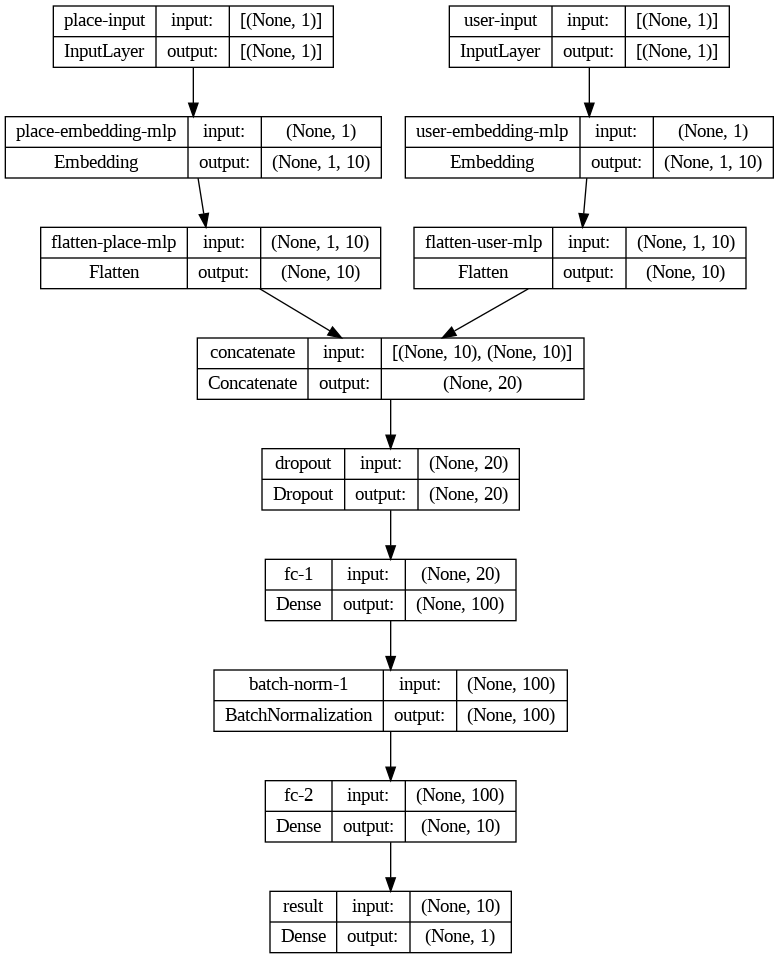

In [ ]:
# Plot model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 place-input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place-embedding-mlp (Embed  (None, 1, 10)                470       ['place-input[0][0]']         
 ding)                                                                                            
                                                                                                  
 user-embedding-mlp (Embedd  (None, 1, 10)                2940      ['user-input[0][0]']      

### Pelatihan Model pada Dataset

In [ ]:
history = model.fit(
    x=[train['User_Id'], train['Place_Id']],
    y=train['Place_Ratings'],
    epochs=1000,
    validation_data=([val['User_Id'], val['Place_Id']], val['Place_Ratings']),
    callbacks=[early_stopping]
)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.7205 - val_loss: 10.8862
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6645 - val_loss: 10.7955
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6254 - val_loss: 10.6968
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5102 - val_loss: 10.5800
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3039 - val_loss: 10.4556
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1944 - val_loss: 10.3137
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0620 - val_loss: 10.1622
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9276 - val_loss: 10.0043
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8738 - val_loss: 9.8267
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6812 - val_loss: 9.6469
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5281 - val_loss: 9.4487
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# import numpy as np
# from sklearn.metrics import confusion_matrix

# # Prediksi nilai pada data validasi
# y_pred = model.predict([test['User_Id'], test['Place_Id']])

# # Jika output Anda menggunakan sigmoid untuk klasifikasi biner
# # Konversi probabilitas menjadi label biner (misalnya 0 atau 1)
# # y_pred = np.round(y_pred_prob).astype(int)

# # Mendapatkan nilai aktual
# y_true = test['Place_Ratings']

# print(y_pred)

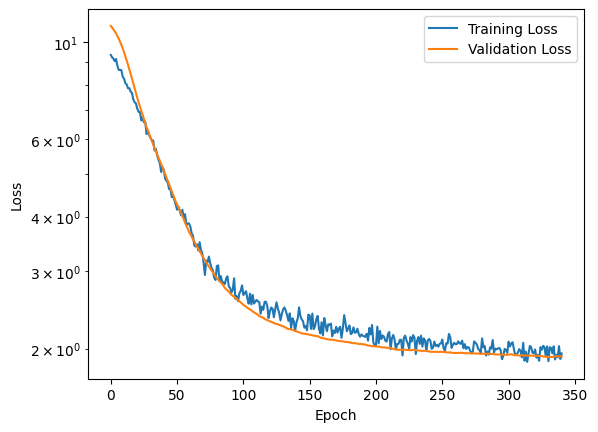

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### RMSE

#### Laten 5

In [ ]:
# train lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 2ms/step
Mean Squared Error: 0.8321564040655475
Root Mean Squared Error: 0.9122260707004308


In [ ]:
# test lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 6ms/step
Mean Squared Error: 2.172136263290732
Root Mean Squared Error: 1.473816902905762


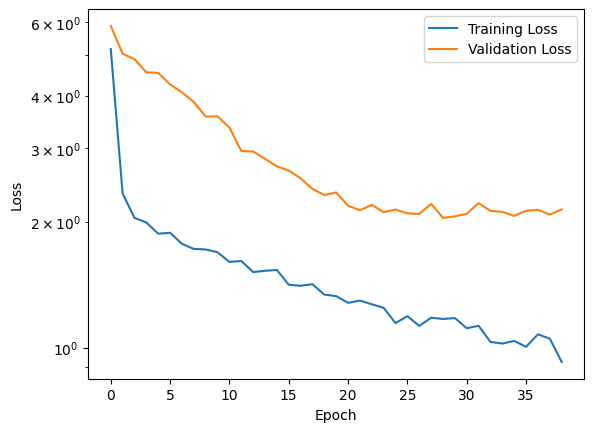

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 1s 2ms/step
Mean Squared Error: 1.6160306174125747
Root Mean Squared Error: 1.271231929040714


In [ ]:
# test lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 2.169877108890628
Root Mean Squared Error: 1.4730502737145899


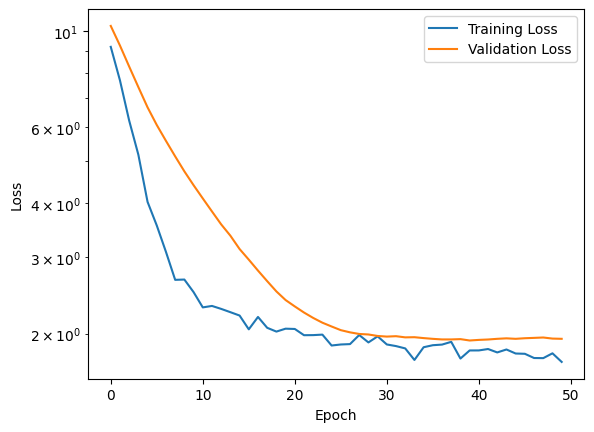

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 2ms/step
Mean Squared Error: 1.737934364277103
Root Mean Squared Error: 1.318307386111867


In [ ]:
# test lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 2.205230300813978
Root Mean Squared Error: 1.4850017847847787


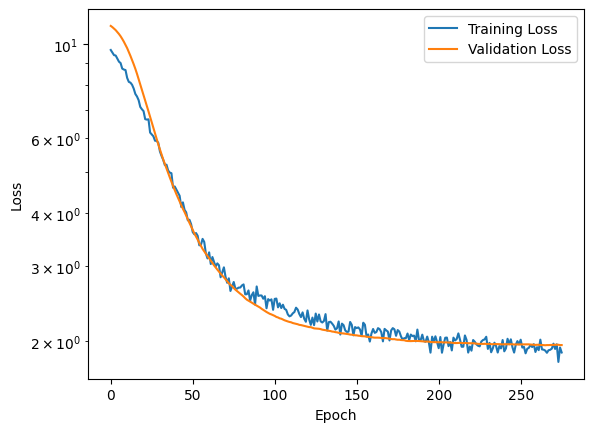

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Laten 10

In [ ]:
# train lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 4ms/step
Mean Squared Error: 0.9258607605529918
Root Mean Squared Error: 0.9622165871325394


In [ ]:
# test lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 6ms/step
Mean Squared Error: 2.0334021181588167
Root Mean Squared Error: 1.425974094490786


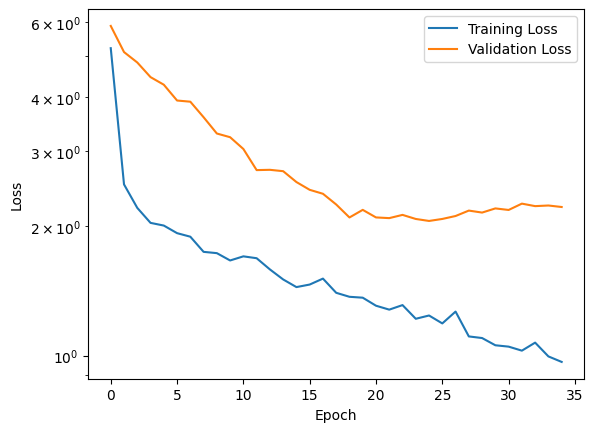

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 3ms/step
Mean Squared Error: 1.5171929250552552
Root Mean Squared Error: 1.2317438552942959


In [ ]:
# test lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 7ms/step
Mean Squared Error: 1.9441594532020963
Root Mean Squared Error: 1.3943311849062605


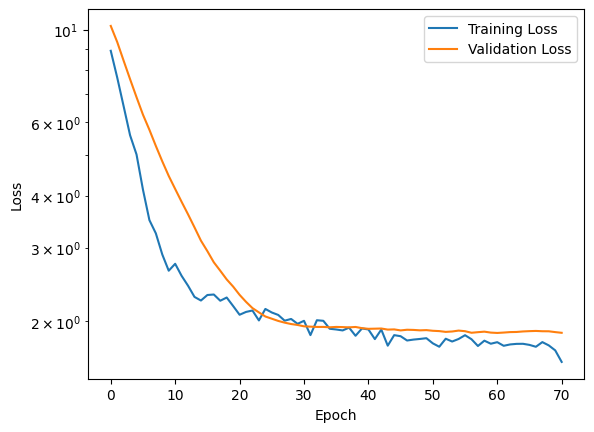

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_train = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y_train = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error: 1.7460414344162276
Root Mean Squared Error: 1.321378611305718


In [ ]:
# test lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error: 2.0382068076135846
Root Mean Squared Error: 1.4276578048025321


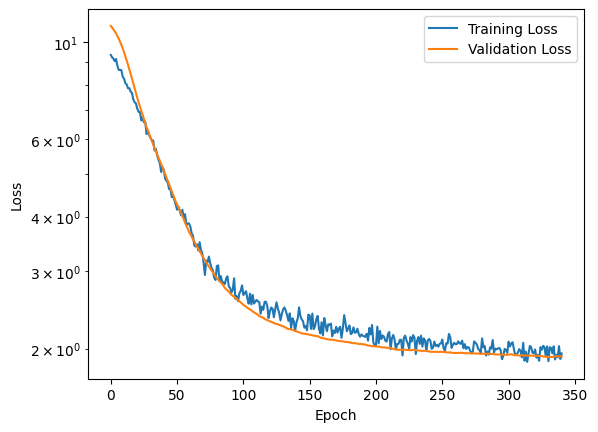

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Laten 50

In [ ]:
# train lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 2ms/step
Mean Squared Error: 0.587605159971812
Root Mean Squared Error: 0.7665540815701212


In [ ]:
# test lr 0.01

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 3ms/step
Mean Squared Error: 2.3087440390617786
Root Mean Squared Error: 1.5194551783655148


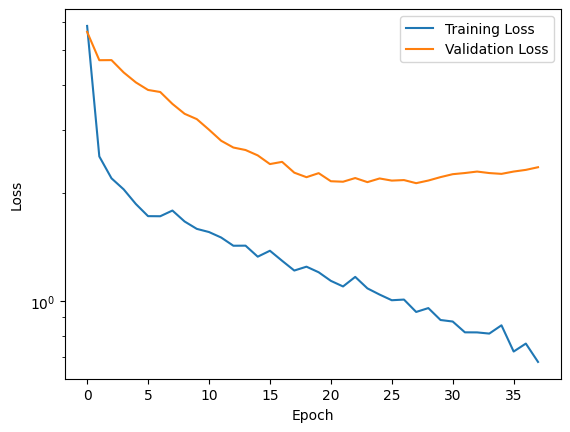

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 4ms/step
Mean Squared Error: 1.525157688936518
Root Mean Squared Error: 1.2349727482566237


In [ ]:
# test lr 0.001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 3ms/step
Mean Squared Error: 2.204163883530522
Root Mean Squared Error: 1.4846426787380598


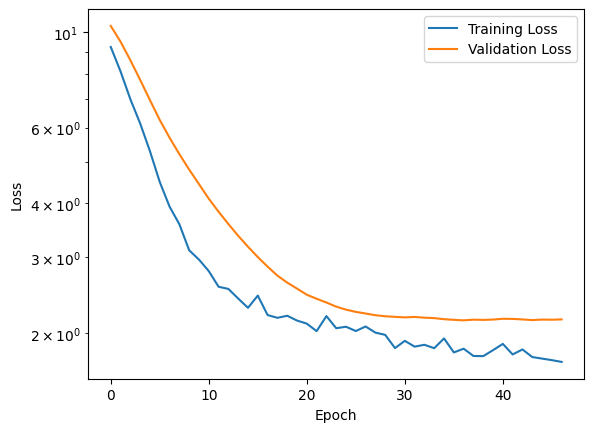

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# train lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([train['User_Id'], train['Place_Id']]).flatten()  # Flatten predictions
y = train['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'train' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

20/20 [==============================] - 0s 2ms/step
Mean Squared Error: 1.5057958036918941
Root Mean Squared Error: 1.2271087171444486


In [ ]:
# test lr 0.0001

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([test['User_Id'], test['Place_Id']]).flatten()  # Flatten predictions
y = test['Place_Ratings']  # Assuming 'rating' column is the true ratings in 'test' data

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
rmse = mean_squared_error(y, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 2.202847799210509
Root Mean Squared Error: 1.484199379871353


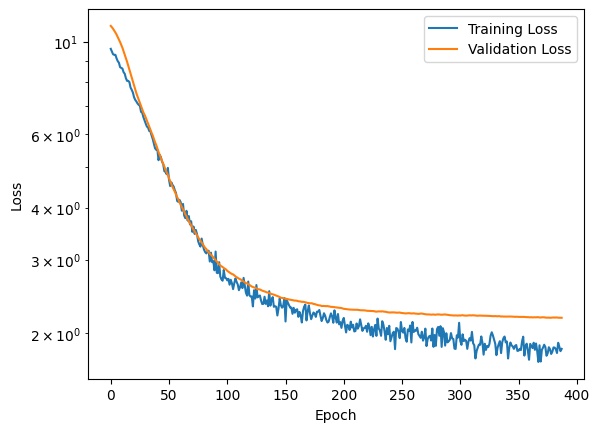

In [ ]:
# Plot training loss dan validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')  # Set log scale untuk sumbu y
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Hasil Prediksi

In [ ]:
pd.set_option('display.max_rows', None)

Rating_Actual=pd.DataFrame(y_train).reset_index()
Rating_Predict=pd.DataFrame(y_pred_train)

hasil=pd.concat([Rating_Actual, Rating_Predict], axis=1)
hasil.columns = ['User_Id', 'Rating_Actual', 'Rating_Predict']
# hasil['Rating_Predict'] = hasil['Rating_Predict'].round(0).astype(int)
hasil

User_Id  Rating_Actual  Rating_Predict
0        114              5        3.462050
1        733              2        2.111795
2        557              5        3.750967
3        487              1        3.013618
4        154              4        3.051930
5        652              3        2.547521
6        181              2        3.399282
7        473              5        3.610911
8        788              3        3.098495
9        229              1        3.055418
10       585              5        3.515984
11       401              5        3.860811
12         0              5        3.736250
13       807              2        2.683241
14       708              1        3.042629
15       772              5        2.849894
16       101              4        2.240564
17       600              1        2.859506
18       574              3        2.347415
19       384              5        3.077128
20        98              4        2.726487
21       438              2        2.641737
22       638              1        2.371609
23       565              5        3.112971
24       337              5        3.617146
25       711              2        2.771785
26       258              3        4.034700
27       217              5        2.932647
28       283              4        3.004708
29       242              3        3.196430
30       963              3        3.803130
31       780              1        2.726331
32       626              2        3.353447
33       472              3        2.391712
34       676              1        3.032269
35       827              5        3.234173
36        32              4        2.660641
37       234              3        3.043067
38       121              5        3.027444
39       267              1        3.503729
40       754              4        3.481819
41       667              5        2.430484
42       703              4        3.325617
43       143              4        3.272855
44       605              2        3.220129
45        84              5        2.814994
46       118              3        3.191243
47       719              4        2.810720
48       369              4        2.778791
49       469              2        3.216570
50       560              1        2.667442
51       704              2        2.337986
52       289              2        3.668931
53       193              4        3.004580
54       916              4        2.630671
55       479              2        2.566586
56       723              1        2.473319
57        56              2        2.891372
58       689              5        3.381388
59        71              5        3.691270
60       564              3        3.650530
61       731              3        3.470361
62       391              4        2.767384
63       613              2        3.214145
64       370              5        3.398917
65        53              3        3.969431
66        65              4        2.701229
67       339              2        3.418241
68       699              4        3.516703
69       830              3        3.027838
70       691              4        3.070678
71       177              2        3.003068
72       901              3        2.583903
73       426              4        2.722203
74       182              5        2.523243
75       481              4        2.863947
76       852              4        3.016509
77        19              5        3.529656
78       439              4        2.976523
79       142              5        3.118599
80       962              1        2.511004
81       293              3        1.918962
82       459              5        3.036641
83       969              1        2.718269
84       109              2        3.530187
85       297              5        2.632653
86       947              1        2.617713
87       816              1        2.086123
88       477              3        2.559747
89       113              2        2.951770
9

In [ ]:
pd.set_option('display.max_rows', None)

Rating_Actual=pd.DataFrame(y).reset_index()
Rating_Predict=pd.DataFrame(y_pred)

hasil_test=pd.concat([Rating_Actual, Rating_Predict], axis=1)
hasil_test.columns = ['User_Id', 'Rating_Actual', 'Rating_Predict']
# hasil_test['Rating_Predict'] = hasil_test['Rating_Predict'].round(0).astype(int)
hasil_test

User_Id  Rating_Actual  Rating_Predict
0        453              4        3.152361
1        792              4        2.482281
2        209              2        3.221080
3        309              1        2.829022
4        739              2        2.858079
5        578              2        2.630236
6        850              4        3.201449
7        545              4        2.234238
8        436              3        2.252351
9        677              2        2.951019
10       934              1        2.719562
11       635              5        2.662847
12       865              1        3.332583
13       603              2        3.004805
14       889              3        2.893259
15        70              5        3.374904
16       823              3        3.434374
17       468              5        3.464940
18       382              3        2.658650
19       208              5        3.770633
20       570              5        2.161643
21       377              2        2.391313
22       927              5        2.920838
23       877              2        2.899977
24       900              3        3.464612
25        59              2        2.607747
26       168              5        2.983420
27       249              5        3.247423
28       809              2        2.179267
29       344              5        2.104354
30       595              4        2.690628
31       318              1        3.092066
32       625              3        2.746848
33       542              3        2.203791
34       622              1        2.905015
35       693              1        2.822103
36       158              5        2.696644
37       198              4        3.517088
38       662              2        3.121096
39       597              1        3.321688
40       787              2        2.936024
41       380              5        3.107868
42       936              2        2.483999
43       425              5        3.198907
44       199              1        2.732014
45       576              4        4.553619
46       266              5        2.515121
47       736              4        3.071708
48        76              2        3.471647
49       869              3        3.719257
50       634              4        2.906474
51       526              5        3.956456
52       781              5        3.243748
53        23              5        2.621573
54        30              5        2.889622
55       327              3        2.579295
56        10              2        3.047206
57       539              3        3.560755
58       541              5        3.898566
59       740              3        2.551906
60        54              5        3.860922
61       975              4        2.141022
62       915              1        2.962182
63       514              3        4.249316
64       706              3        3.180489
65       371              2        2.267571
66       507              1        2.485243
67       730              1        2.817568
68       260              4        2.483290
69       881              5        3.069139
70        96              4        2.937093
71       107              3        3.729850
72       650              4        3.905886
73       174              2        3.478886
74       521              1        2.652363
75       912              3        3.079182
76        39              5        2.793211
77       714              5        2.742989
78       522              3        3.016884
79       973              3        1.637515
80        66              2        2.819334
81       558              3        2.510213
82        67              4        3.426602
83       879              2        2.787630
84       352              1        2.836279
85       433              2        2.755432
86       649              4        3.529488
87       513              3        2.966701
88       449              1        2.926553
89       485              4        2.791688
9

### Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Buat kolom biner
threshold = 2.5
hasil['Actual_Binary'] = hasil['Rating_Actual'] > threshold
hasil['Predict_Binary'] = hasil['Rating_Predict'] > threshold

# Hitung confusion matrix
cm = confusion_matrix(hasil['Actual_Binary'], hasil['Predict_Binary'])
accuracy = accuracy_score(hasil['Actual_Binary'], hasil['Predict_Binary'])
precision = precision_score(hasil['Actual_Binary'], hasil['Predict_Binary'])
recall = recall_score(hasil['Actual_Binary'], hasil['Predict_Binary'])
f1 = f1_score(hasil['Actual_Binary'], hasil['Predict_Binary'])

# Tampilkan hasil
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Confusion Matrix:
[[ 56 173]
 [ 50 359]]
Accuracy: 0.65
Precision: 0.67
Recall: 0.88
F1 Score: 0.76


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# # Buat kolom biner
# threshold = 2.5
# hasil_test['Actual_Binary'] = hasil_test['Rating_Actual'] > threshold
# hasil_test['Predict_Binary'] = hasil_test['Rating_Predict'] > threshold

# # Hitung confusion matrix
# cm = confusion_matrix(hasil_test['Actual_Binary'], hasil_test['Predict_Binary'])
# accuracy = accuracy_score(hasil_test['Actual_Binary'], hasil_test['Predict_Binary'])
# precision = precision_score(hasil_test['Actual_Binary'], hasil_test['Predict_Binary'])
# recall = recall_score(hasil_test['Actual_Binary'], hasil_test['Predict_Binary'])
# f1 = f1_score(hasil_test['Actual_Binary'], hasil_test['Predict_Binary'])

# # Tampilkan hasil_test
# print("Confusion Matrix:")
# print(cm)
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(hasil['Rating_Actual'], hasil['Rating_Predict'])
conf_matrix

array([[ 0,  5, 26,  2,  0],
       [ 1,  5, 31,  4,  0],
       [ 0,  8, 26,  6,  0],
       [ 0,  8, 26,  6,  0],
       [ 0,  6, 31,  9,  0]])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(hasil['Rating_Actual'], hasil['Rating_Predict'])
precision = precision_score(hasil['Rating_Actual'], hasil['Rating_Predict'], average='weighted')
recall = recall_score(hasil['Rating_Actual'], hasil['Rating_Predict'], average='weighted')
f1 = f1_score(hasil['Rating_Actual'], hasil['Rating_Predict'], average='weighted')

print("\nNilai Akurasi: {:.2f}".format(accuracy))
print("Nilai Presisi: {:.2f}".format(precision))
print("Nilai Recall: {:.2f}".format(recall))
print("Nilai F1-Score: {:.2f}".format(f1))


Nilai Akurasi: 0.18
Nilai Presisi: 0.11
Nilai Recall: 0.18
Nilai F1-Score: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# laten 10 lr 0.0001
hasil.describe()

User_Id  Rating_Actual  Rating_Predict
count  200.000000     200.000000      200.000000
mean   510.355000       3.125000        2.931653
std    285.402156       1.406866        0.498724
min     10.000000       1.000000        1.387546
25%    280.750000       2.000000        2.601019
50%    523.500000       3.000000        2.886003
75%    775.000000       4.000000        3.227702
max    993.000000       5.000000        4.385521

In [ ]:
# Data baru untuk prediksi
new_user_ids = [5, 5, 5, 5, 5, 5, 5, 5, 5]
new_place_ids = [1, 2, 3, 6, 8, 11, 44, 45, 46]

# Pastikan data dalam format numpy array
new_user_ids = np.array(new_user_ids)
new_place_ids = np.array(new_place_ids)

# Lakukan prediksi
y_pred_new = model.predict([new_user_ids, new_place_ids]).flatten()

# Output prediksi
predictions = pd.DataFrame({
    'User_Id': new_user_ids,
    'Place_Id': new_place_ids,
    'Predicted_Rating': y_pred_new
})
predictions

1/1 [==============================] - 0s 133ms/step


User_Id  Place_Id  Predicted_Rating
0        5         1          3.385083
1        5         2          3.729377
2        5         3          3.804992
3        5         6          3.685250
4        5         8          2.793709
5        5        11          3.060065
6        5        44          3.173880
7        5        45          4.017067
8        5        46          3.863582

In [ ]:
import numpy as np
import pandas as pd

# Data baru untuk prediksi
new_user_ids = [5] * 46  # Mengisi new_user_ids dengan nilai 5 sebanyak 46 baris
new_place_ids = list(range(1, 47))  # Mengisi new_place_ids dengan angka urut dari 1 sampai 46

# Pastikan data dalam format numpy array
new_user_ids = np.array(new_user_ids)
new_place_ids = np.array(new_place_ids)

# Lakukan prediksi (gunakan model yang sudah terlatih)
y_pred_new = model.predict([new_user_ids, new_place_ids]).flatten()

# Output prediksi
predictions = pd.DataFrame({
    'User_Id': new_user_ids,
    'Place_Id': new_place_ids,
    'Predicted_Rating': y_pred_new
})

# Tampilkan hasil prediksi
predictions

2/2 [==============================] - 0s 7ms/step


User_Id  Place_Id  Predicted_Rating
0         5         1          3.385083
1         5         2          3.729377
2         5         3          3.804992
3         5         4          3.852060
4         5         5          3.713114
5         5         6          3.685250
6         5         7          3.553826
7         5         8          2.793709
8         5         9          2.058613
9         5        10          3.422308
10        5        11          3.060065
11        5        12          3.424111
12        5        13          3.310896
13        5        14          3.295985
14        5        15          2.802742
15        5        16          3.932940
16        5        17          3.879831
17        5        18          3.670299
18        5        19          3.353586
19        5        20          3.014077
20        5        21          3.582277
21        5        22          2.972470
22        5        23          3.820158
23        5        24          3.232605
24        5        25          3.291008
25        5        26          2.613322
26        5        27          3.476081
27        5        28          3.804501
28        5        29          4.463370
29        5        30          3.154834
30        5        31          3.242288
31        5        32          2.834198
32        5        33          2.591117
33        5        34          3.534533
34        5        35          3.876521
35        5        36          4.123052
36        5        37          3.165949
37        5        38          2.831993
38        5        39          2.324913
39        5        40          2.598816
40        5        41          3.520975
41        5        42          4.001538
42        5        43          2.771499
43        5        44          3.173880
44        5        45          4.017068
45        5        46          3.863581

### Hasil Rekomendasi

In [ ]:
import numpy as np
import pandas as pd

# Data baru untuk prediksi
new_user_ids = [5] * 46  # Mengisi new_user_ids dengan nilai 5 sebanyak 46 baris
new_place_ids = list(range(1, 47))  # Mengisi new_place_ids dengan angka urut dari 1 sampai 46

# Pastikan data dalam format numpy array
new_user_ids = np.array(new_user_ids)
new_place_ids = np.array(new_place_ids)

# Lakukan prediksi (gunakan model yang sudah terlatih)
y_pred_new = model.predict([new_user_ids, new_place_ids]).flatten()

# Output prediksi
predictions = pd.DataFrame({
    'User_Id': new_user_ids,
    'Place_Id': new_place_ids,
    'Predicted_Rating': y_pred_new
})

# Urutkan berdasarkan Predicted_Rating dari yang terbesar
predictions = predictions.sort_values(by='Predicted_Rating', ascending=False).reset_index(drop=True)

# Tampilkan hasil prediksi
predictions

2/2 [==============================] - 0s 11ms/step


User_Id  Place_Id  Predicted_Rating
0         5        29          4.463370
1         5        36          4.123052
2         5        45          4.017068
3         5        42          4.001538
4         5        16          3.932940
5         5        17          3.879831
6         5        35          3.876521
7         5        46          3.863581
8         5         4          3.852060
9         5        23          3.820158
10        5         3          3.804992
11        5        28          3.804501
12        5         2          3.729377
13        5         5          3.713114
14        5         6          3.685250
15        5        18          3.670299
16        5        21          3.582277
17        5         7          3.553826
18        5        34          3.534533
19        5        41          3.520975
20        5        27          3.476081
21        5        12          3.424111
22        5        10          3.422308
23        5         1          3.385083
24        5        19          3.353586
25        5        13          3.310896
26        5        14          3.295985
27        5        25          3.291008
28        5        31          3.242288
29        5        24          3.232605
30        5        44          3.173880
31        5        37          3.165949
32        5        30          3.154834
33        5        11          3.060065
34        5        20          3.014077
35        5        22          2.972470
36        5        32          2.834198
37        5        38          2.831993
38        5        15          2.802742
39        5         8          2.793709
40        5        43          2.771499
41        5        26          2.613322
42        5        40          2.598816
43        5        33          2.591117
44        5        39          2.324913
45        5         9          2.058613